### Central Motivation & Key Questions

Names: Sam Lewis, Ekaterina Sivokon, Angelia Loo, Aditya Bisht

This project’s central motivation is to use data to evaluate the effectiveness of existing approaches to overcome the challenges associated with cancer treatment, as well as to discover causal and consequential relationships between different aspects of cancer treatment plans and identify patterns in how demographic factors correlate with specific cancer diagnoses.  We hope the project's outcomes could potentially improve treatment strategies. The key questions that drive our investigation are:  

**Question 1. Can we predict patient survival outcomes based on demographic characteristics and cancer type, particularly for the most common cancer sites in our dataset (bronchus and lung, colon, breast)?**  

**Question 2. How do demographic factors (race, gender) correlate with cancer type distribution and survival outcomes?**  

The purpose of these questions is to understand the relationships between patient demographics and cancer outcomes, with particular attention to:  
- Gender-based differences in cancer type distribution and survival  
- Racial/ethnic patterns in cancer diagnosis and outcomes  
- Site-specific survival patterns across different demographic groups  

To answer these questions, we will:  

The purpose of this question is to find a quantifiable relationship between various treatment practices and patients’ outcomes, differentiating by cancer type. Through these correlations, we hope to understand which treatments are the most promising for specific cancer types. To answer this question, we will:  

1) Analyze data from the National Cancer Institute's Genomic Data Commons:
    1. Collect treatment data (type of treatment, duration, dosage, etc.)  
    2. Collect patient outcome data (survival rates, disease progression)  
    3. Categorize data by specific cancer types  

2) Use statistical analysis techniques such as:  
    1. Survival analysis, such as Kaplan-Meier curves: 
The Kaplan-Meier survival curve is defined as the probability of surviving in a given length of time while considering time in many [small intervals](https://pmc.ncbi.nlm.nih.gov/articles/PMC3059453/#ref3)  
=> allows to estimate the relationship between different treatments and survival times for each cancer type
    2. Multiple linear regression:  
method of modeling multiple responses, or dependent variables, with a single set of predictor variables. For example, we might want to model both math and reading SAT scores as a function of gender, race, parent income, and [so forth](https://library.virginia.edu/data/articles/getting-started-with-multivariate-multiple-regression#:~:text=Multivariate%20Multiple%20Regression%20is%20a,parent%20income%2C%20and%20so%20forth.)  
=> allows to control for intersecting factors: age, stage of cancer, etc.  
Possibly: analyzing subgroups: are certain treatments more effective for specific patient demographics or cancer types?  
    3. Classification Modelling:
Utilize the data available, such as demographic data, cancer type, and treatment type to build a classification model to predict the probability of survival

3) Visualize the results:  
    1. Scatter Plot: treatment duration vs. patient survival time  
=> identify optimal treatment durations & any diminishing returns from prolonged treatment
(when benefits of continuing a cancer treatment decrease over time, while the risks and side effects may increase)  
    2. Pie Chart: treatment distribution  
=> proportion of patients receiving each type of treatment; gives context for the prevalence of anyt treatment approaches  
    3. Heat maps: Effectiveness of treatments for various cancer types  
X-axis: treatment approaches (Chemotherapy/Radiation/Immunotherapy/Surgery);  
Y-axis: cancer types (Lung/Breast/Colon/Prostate/Melanoma);  
Color intensity will represent the effectiveness of the treatment, for example, n-year survival rate or some other measure of treatment success  
    4. The Sankey diagram (Image 1) shows:  
Race/ethnicity distribution (white, asian, unknown, etc.)  
Gender distribution (male, female)  
Cancer types (Glioblastoma, Adenocarcinoma NOS, Malignant melanoma NOS, Infiltrating duct carcinoma NOS)  

### Obtain, Clean, and Merge all data sources

In [1]:
import requests
import json
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import combinations

pd.set_option('display.max_columns', None)

## Data Pipeline

#### Summary Steps

1. Write a function that gets all the project id's for a particular project type
2. Get all the cases for a particular project id. Using this function, we can also specify the fields of interest to pull for each case
3. Create some basic analysis to determine which projects have the highest quality data
4. Select a project to be used for analysis and modelling
5. Pull and clean the project data based on it's relatively specific structure

#### Detailed Explanation
The GDC database / API, after digging through the documentation, is structured as follows. There are large studies which are classified into projects.
Each project has a project type. We are interested in the clinical projects because those are the projects that have the interesting information regarding treatments
and outcomes. Each project has a large amount of cases. A case contains the result from one patient of the project. Each case has the interesting information that we 
can study, including the type of cancer, treatment, outcome, and more.

Importantly, the data structure for each project is somewhat specific. This makes it difficult to combine together the data from many projects. For this reason, a high level analysis will be conducted regarding the quality of data from each project for the specific fields of interest. The project with the most quality regarding the fields of interest will be selected for the analysis and fully cleaned.

To undertake the high level analysis of data quality across projects and select a project, we start with the function `get_proj_ids_by_type()` to get all project IDs for the `Clinical` project type. Then, for each project ID of `Clinical` type, we use the function `get_cases_by_proj_id()` to assemble a pandas DataFrame containing the fields of interest for all cases of all clinical projects. Using this dataframe we will perform some high level analysis to inform the project with the highest quality data.

After selecting a project based on the preliminary analysis, the function `get_cases_by_proj_id()` can be used to assemble a pandas DataFrame containing the case data for the selected project. The data will then be cleaned according to the specific structure and information available. Some important data cleaning operations will include un-nesting JSON fields, creating calculating columns, string cleaning, type conversion, and dropping or imputing missing values.

In [2]:
def get_proj_ids_by_type(category):
    '''
    Call the https://api.gdc.cancer.gov/projects endpoint of the GDC API to get all the project IDs for a certain data category
    
    Args:
        category (str) - the category of projects of interest
    
    Returns:
        proj_ids (list of str)
    '''

    # make API call filtered on project category
    response = requests.get('https://api.gdc.cancer.gov/projects',
                             params={'filters': json.dumps({'op': 'in', 
                                     'content': {'field': 'summary.data_categories.data_category','value': [category]}}),
                                     'fields': 'project_id',
                                    'format': 'JSON',
                                    'size': 10000})

    # create list of project IDs
    projects = response.json()['data']['hits']
    proj_ids = [project['project_id'] for project in projects]

    return proj_ids

In [3]:
def get_cases_by_proj_id(proj_id, fields):
    '''
    Call the https://api.gdc.cancer.gov/cases endpoint of the GDC API to get all the cases for a particular project ID.
    Also specify a list of fields to be returned for each case 
    
    Args:
        proj_id (str) - the project id to pull cases for
        fields (list of str) - the fields to be returned for each case
    
    Returns:
        cases (dictionary) - a dictionary of case data for the specified project id, containing the specified fields in JSON format
    '''

    # make API call filtered on project ID requesting the provided fields
    response = requests.get('https://api.gdc.cancer.gov/cases',
                             params={'filters': json.dumps({'op': 'in', 
                                     'content': {'field': 'project.project_id','value': [proj_id]}}),
                                     'fields': ','.join(fields),
                                    'format': 'JSON',
                                    'size':10000})

    # create a dictionary of cases data
    data = json.loads(response.text)

    return data

In [4]:
# get project IDs for clinical trials
proj_ids = get_proj_ids_by_type('Clinical')
proj_ids[:5]


['TARGET-AML', 'MATCH-Z1I', 'HCMI-CMDC', 'MATCH-W', 'MATCH-Z1D']

### Analyze viability of data for each project

In [5]:
# fields of interest
fields = ['project.project_id', 'diagnoses.treatments.treatment_type', 'diagnoses.treatments.treatment_intent_type',
          'diagnoses.tissue_or_organ_of_origin', 'diagnoses.age_at_diagnosis', 'diagnoses.primary_diagnosis', 'demographic.ethnicity',
          'demographic.gender', 'demographic.race', 'demographic.vital_status', 'demographic.days_to_death', 'diagnoses.diagnosis_is_primary_disease']

# pull all clinical project data for desired fields
all_json_data = [get_cases_by_proj_id(proj, fields) for proj in proj_ids]
all_proj_data = pd.concat([pd.json_normalize(json_data['data']['hits']) for json_data in all_json_data])
all_proj_data = all_proj_data.dropna(how='all', axis=1)

C:\Users\looan\AppData\Local\Temp\ipykernel_16400\1722049920.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_proj_data = pd.concat([pd.json_normalize(json_data['data']['hits']) for json_data in all_json_data])


In [6]:
# un-nest the diagnoses column
all_proj_data.dropna(subset=['diagnoses'], inplace=True, ignore_index=True)
all_proj_data = pd.concat([all_proj_data.drop(columns='diagnoses'), pd.json_normalize(all_proj_data.diagnoses.apply(lambda x: x[0]))], axis=1)
all_proj_data.head()

id project.project_id  \
0  58771370-5082-485e-ac68-13edfbd9ef0c         TARGET-AML   
1  28da5b52-29ed-4817-a678-9206c5164da0         TARGET-AML   
2  28ffdfb9-f051-4424-ad35-e6633e6bf42e         TARGET-AML   
3  29312892-078e-4a35-809c-729f55370967         TARGET-AML   
4  58aa0126-221e-41ec-841c-9fd0ab0b2a53         TARGET-AML   

            demographic.race demographic.gender   demographic.ethnicity  \
0                      asian               male  not hispanic or latino   
1                      white             female      hispanic or latino   
2                      white             female  not hispanic or latino   
3  black or african american               male  not hispanic or latino   
4                      other               male  not hispanic or latino   

  demographic.vital_status  demographic.days_to_death  \
0                     Dead                      939.0   
1                    Alive                        NaN   
2                    Alive                        NaN   
3                     Dead                      191.0   
4                    Alive                        NaN   

  tissue_or_organ_of_origin  age_at_diagnosis            primary_diagnosis  \
0               Bone marrow            3551.0  Acute myeloid leukemia, NOS   
1               Bone marrow            4780.0  Acute myeloid leukemia, NOS   
2               Bone marrow             492.0  Acute myeloid leukemia, NOS   
3               Bone marrow            3505.0  Acute myeloid leukemia, NOS   
4               Bone marrow             553.0  Acute myeloid leukemia, NOS   

  diagnosis_is_primary_disease  \
0                         True   
1                         True   
2                         True   
3                         True   
4                         True   

                                          treatments  
0  [{'treatment_type': 'Stem Cell Transplantation...  
1  [{'treatment_type': 'Stem Cell Transplantation...  
2  [{'treatment_type': 'Stem Cell Transplantation...  
3  [{'treatment_type': 'Stem Cell Transplantation...  
4  [{'treatment_type': 'Stem Cell Transplantation...

In [7]:
# look at percent missing, number unique primary diagnoses, number unique tissue/organ of origin, record count for all projects
record_count = pd.DataFrame(all_proj_data.groupby('project.project_id').size()).rename(columns={0:'record_count'})
unique_primary = pd.DataFrame(all_proj_data.groupby('project.project_id')['primary_diagnosis'].nunique()).rename(
                            columns={'primary_diagnosis':'nunique_primary'})
unique_origin = pd.DataFrame(all_proj_data.groupby('project.project_id')['tissue_or_organ_of_origin'].nunique()).rename(
                            columns={'tissue_or_organ_of_origin':'nunique_origin'})

percent_missing = pd.concat([all_proj_data.iloc[:, 1], all_proj_data.iloc[:, 2:].isna()], axis=1)
percent_missing = percent_missing.groupby('project.project_id').sum() / percent_missing.groupby('project.project_id').count()
percent_missing['avg % missing'] = percent_missing.mean(axis=1)

proj_analysis = pd.concat([percent_missing, record_count, unique_primary, unique_origin], axis=1)
proj_analysis.sort_values(by='avg % missing', inplace=True)
proj_analysis[['avg % missing', 'record_count', 'nunique_primary', 'nunique_origin']].head(10)


avg % missing  record_count  nunique_primary  \
project.project_id                                                 
CDDP_EAGLE-1             0.038000            50                5   
TARGET-AML               0.069621          2189                1   
CGCI-HTMCP-CC            0.092925           212               15   
HCMI-CMDC                0.098921           278               37   
CGCI-BLGSP               0.102167           323                8   
CGCI-HTMCP-DLBCL         0.114286            70                5   
CGCI-HTMCP-LC            0.115385            39               14   
TCGA-MESO                0.116092            87                4   
TCGA-GBM                 0.118531           599                1   
TCGA-UCS                 0.138596            57                3   

                    nunique_origin  
project.project_id                  
CDDP_EAGLE-1                     4  
TARGET-AML                       1  
CGCI-HTMCP-CC                    2  
HCMI-CMDC                       26  
CGCI-BLGSP                       8  
CGCI-HTMCP-DLBCL                 2  
CGCI-HTMCP-LC                    9  
TCGA-MESO                        1  
TCGA-GBM                         5  
TCGA-UCS                         2

The HCMI-CMDC project is the best fit for our analysis for a few reasons. First, it has a relatively low number of missing values and it has > 30 observations which is essential for the feasibility of our modeling. Additionally, the main factor which sets this project apart from some of the similar projects is that is has the largest number of unique primary diagnoses and unique tissues of origin. This will make for a more comprehensive analysis compared to a project like TARGET-AML, which has more observations but only 1 diagnoses and 1 tissue of origin

### Pull and clean data for selected project

In [8]:
# fields of interest
fields = ['diagnoses.treatments.treatment_type', 'diagnoses.treatments.treatment_intent_type',
          'diagnoses.tissue_or_organ_of_origin', 'diagnoses.age_at_diagnosis', 'diagnoses.primary_diagnosis', 'demographic.ethnicity',
          'demographic.gender', 'demographic.race', 'demographic.vital_status', 'demographic.days_to_death', 'diagnoses.diagnosis_is_primary_disease']

# using HCMI-CMDC project
json_data_HCMI_CMDC = get_cases_by_proj_id('HCMI-CMDC', fields)
data_HCMI_CMDC = pd.json_normalize(json_data_HCMI_CMDC['data']['hits'])

# if person is alive, replace days_to_death with -1
data_HCMI_CMDC.loc[data_HCMI_CMDC['demographic.vital_status'] == 'Alive', 'demographic.days_to_death'] = -1

# un-nest the diagnoses column which is not handled well by the pandas function
data_HCMI_CMDC = pd.concat([data_HCMI_CMDC.drop(columns='diagnoses'), pd.json_normalize(data_HCMI_CMDC.diagnoses.apply(lambda x: x[0]))], axis=1)
data_HCMI_CMDC.dropna(inplace=True, ignore_index=True)

data_HCMI_CMDC.head()


id demographic.race demographic.gender  \
0  69eced5b-1e76-45c9-bc9c-2aa71a921c57            white               male   
1  e3b32485-b204-43a7-93a5-601408fcdf96     not reported               male   
2  4829dd8c-5445-41b3-ae37-bbcc333e8c9e            white             female   
3  d420e653-3fb2-432b-9e81-81232a80264d            white             female   
4  bfe15f44-e1dd-46ed-b429-908822d0a781            white               male   

    demographic.ethnicity demographic.vital_status  demographic.days_to_death  \
0  not hispanic or latino                     Dead                      373.0   
1            not reported                    Alive                       -1.0   
2                 Unknown                     Dead                     1011.0   
3  not hispanic or latino                     Dead                      481.0   
4  not hispanic or latino                    Alive                       -1.0   

  tissue_or_organ_of_origin  age_at_diagnosis  \
0                Brain, NOS           19996.0   
1             Pancreas, NOS           19813.0   
2               Rectum, NOS           17316.0   
3                Brain, NOS           19586.0   
4                Colon, NOS           27431.0   

                  primary_diagnosis  diagnosis_is_primary_disease  \
0                      Glioblastoma                          True   
1  Infiltrating duct carcinoma, NOS                          True   
2               Adenocarcinoma, NOS                          True   
3                      Glioblastoma                          True   
4               Adenocarcinoma, NOS                          True   

                                          treatments  
0  [{'treatment_intent_type': 'Adjuvant', 'treatm...  
1  [{'treatment_intent_type': 'Adjuvant', 'treatm...  
2  [{'treatment_intent_type': 'Maintenance Therap...  
3  [{'treatment_intent_type': 'Adjuvant', 'treatm...  
4  [{'treatment_intent_type': 'Neoadjuvant', 'tre...

In [9]:
# unnest and create some calculated fields from the treatment column
def parse_treatments_json(json_list):
    '''
    Parses treatment jsons and creates a dataframe with calculated columns for treatment information of each case
    Returned DataFrame will contain the following columns
        - total_times_treatmented: number of treatments administered
        - primary_treatment: the primary treatment for the disease with the highest number of occurences
        - primary_adj_treatment: the Adjuvant treatment with the highest number of occurences
        - primary_neoadj_treatment: the Neoadjuvant treatment with the highest number of occurences
    
    Args:
        json_list: a list of JSON representations of treatment data. JSONs are converted to python objects
        (list and dict). For one case, the JSON takes the form [{treatment_intent_type: val, treatment_type: val}]
    
    Returns:
        treatment_data (pd.DataFrame): - a DataFrame containing treatment information for each case
    '''
    # initialize lists to store data
    total_times_treated = []
    primary_treatment = []
    primary_adj_treatment = []
    primary_neoadj_treatment = []

    # iterate over list of jsons to collect treatment data
    for json in json_list:
        value_counts = {'Adjuvant': defaultdict(int),
                        'Neoadjuvant': defaultdict(int),
                        'None': defaultdict(int)}
        total_times_treated.append(int(len(json)))

        for dct in json:
            # skip non-relevant records
            if dct.get('treatment_type') is None or str(dct.get('treatment_intent_type')) not in ('Adjuvant', 'Neoadjuvant', 'None'):
                continue
            
            value_counts[str(dct.get('treatment_intent_type'))][str(dct['treatment_type'])] += 1

        # append treatments with maximum number of occurences
        primary_adj_treatment.append(max(value_counts['Adjuvant'], key=value_counts['Adjuvant'].get, default="None"))
        primary_treatment.append(max(value_counts['None'], key=value_counts['None'].get, default="None"))
        primary_neoadj_treatment.append(max(value_counts['Neoadjuvant'], key=value_counts['Neoadjuvant'].get, default="None"))

    treatment_data = pd.DataFrame({'total_times_treated': total_times_treated,
                                  'primary_treatment': primary_treatment,
                                  'primary_adj_treatment': primary_adj_treatment,
                                  'primary_neoadj_treatment': primary_neoadj_treatment})
    
    return treatment_data


In [10]:
# add treatment columns to the DataFrame
data_HCMI_CMDC = pd.concat([data_HCMI_CMDC.drop(columns='treatments'), parse_treatments_json(data_HCMI_CMDC.treatments)], axis=1)
data_HCMI_CMDC.head()

id demographic.race demographic.gender  \
0  69eced5b-1e76-45c9-bc9c-2aa71a921c57            white               male   
1  e3b32485-b204-43a7-93a5-601408fcdf96     not reported               male   
2  4829dd8c-5445-41b3-ae37-bbcc333e8c9e            white             female   
3  d420e653-3fb2-432b-9e81-81232a80264d            white             female   
4  bfe15f44-e1dd-46ed-b429-908822d0a781            white               male   

    demographic.ethnicity demographic.vital_status  demographic.days_to_death  \
0  not hispanic or latino                     Dead                      373.0   
1            not reported                    Alive                       -1.0   
2                 Unknown                     Dead                     1011.0   
3  not hispanic or latino                     Dead                      481.0   
4  not hispanic or latino                    Alive                       -1.0   

  tissue_or_organ_of_origin  age_at_diagnosis  \
0                Brain, NOS           19996.0   
1             Pancreas, NOS           19813.0   
2               Rectum, NOS           17316.0   
3                Brain, NOS           19586.0   
4                Colon, NOS           27431.0   

                  primary_diagnosis  diagnosis_is_primary_disease  \
0                      Glioblastoma                          True   
1  Infiltrating duct carcinoma, NOS                          True   
2               Adenocarcinoma, NOS                          True   
3                      Glioblastoma                          True   
4               Adenocarcinoma, NOS                          True   

   total_times_treated primary_treatment               primary_adj_treatment  \
0                   10      Surgery, NOS                        Chemotherapy   
1                    6      Surgery, NOS              Radiation Therapy, NOS   
2                    9      Surgery, NOS              Radiation Therapy, NOS   
3                    6      Surgery, NOS  Immunotherapy (Including Vaccines)   
4                    4      Surgery, NOS              Radiation Therapy, NOS   

  primary_neoadj_treatment  
0                     None  
1                     None  
2                     None  
3                     None  
4                     None

In [11]:
# do some final cleaning of missing values
data_HCMI_CMDC.drop(data_HCMI_CMDC[(data_HCMI_CMDC['demographic.race'] == 'Unknown') | (data_HCMI_CMDC['demographic.race'] == 'not reported')].index, axis=0, inplace=True)
data_HCMI_CMDC.drop(data_HCMI_CMDC[(data_HCMI_CMDC['demographic.ethnicity'] == 'Unknown') | (data_HCMI_CMDC['demographic.ethnicity'] == 'not reported')].index, axis=0, inplace=True)
data_HCMI_CMDC.reset_index(drop=True, inplace=True)

# check out final DataFrame. Data looks good!
data_HCMI_CMDC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            140 non-null    object 
 1   demographic.race              140 non-null    object 
 2   demographic.gender            140 non-null    object 
 3   demographic.ethnicity         140 non-null    object 
 4   demographic.vital_status      140 non-null    object 
 5   demographic.days_to_death     140 non-null    float64
 6   tissue_or_organ_of_origin     140 non-null    object 
 7   age_at_diagnosis              140 non-null    float64
 8   primary_diagnosis             140 non-null    object 
 9   diagnosis_is_primary_disease  140 non-null    bool   
 10  total_times_treated           140 non-null    int64  
 11  primary_treatment             140 non-null    object 
 12  primary_adj_treatment         140 non-null    object 
 13  prima

### Numerical Analysis & Visualizations

In [12]:
# numerical analysis and visualizations here

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

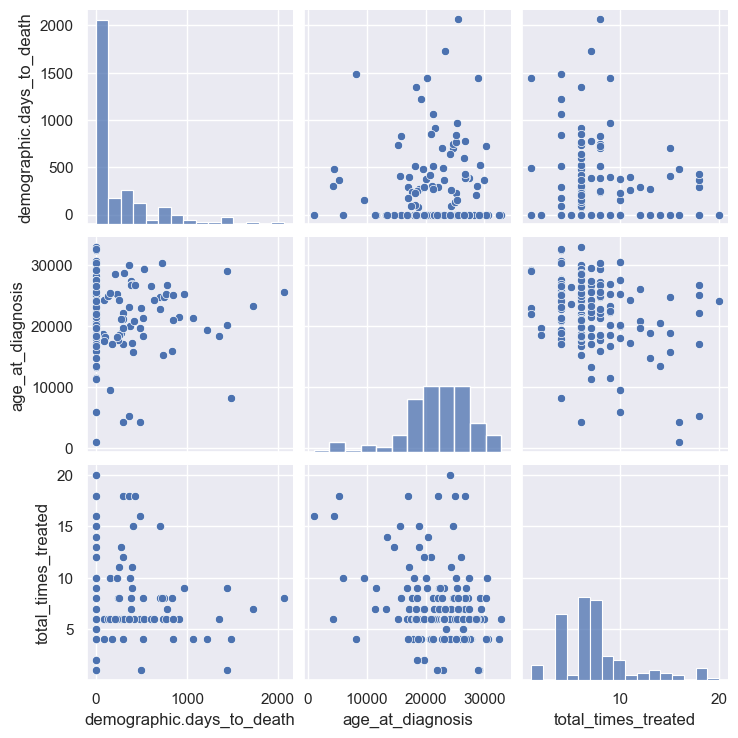

In [14]:
# understand feature distributions at a high level for numeric features
sns.pairplot(data=data_HCMI_CMDC.select_dtypes(include='number'))

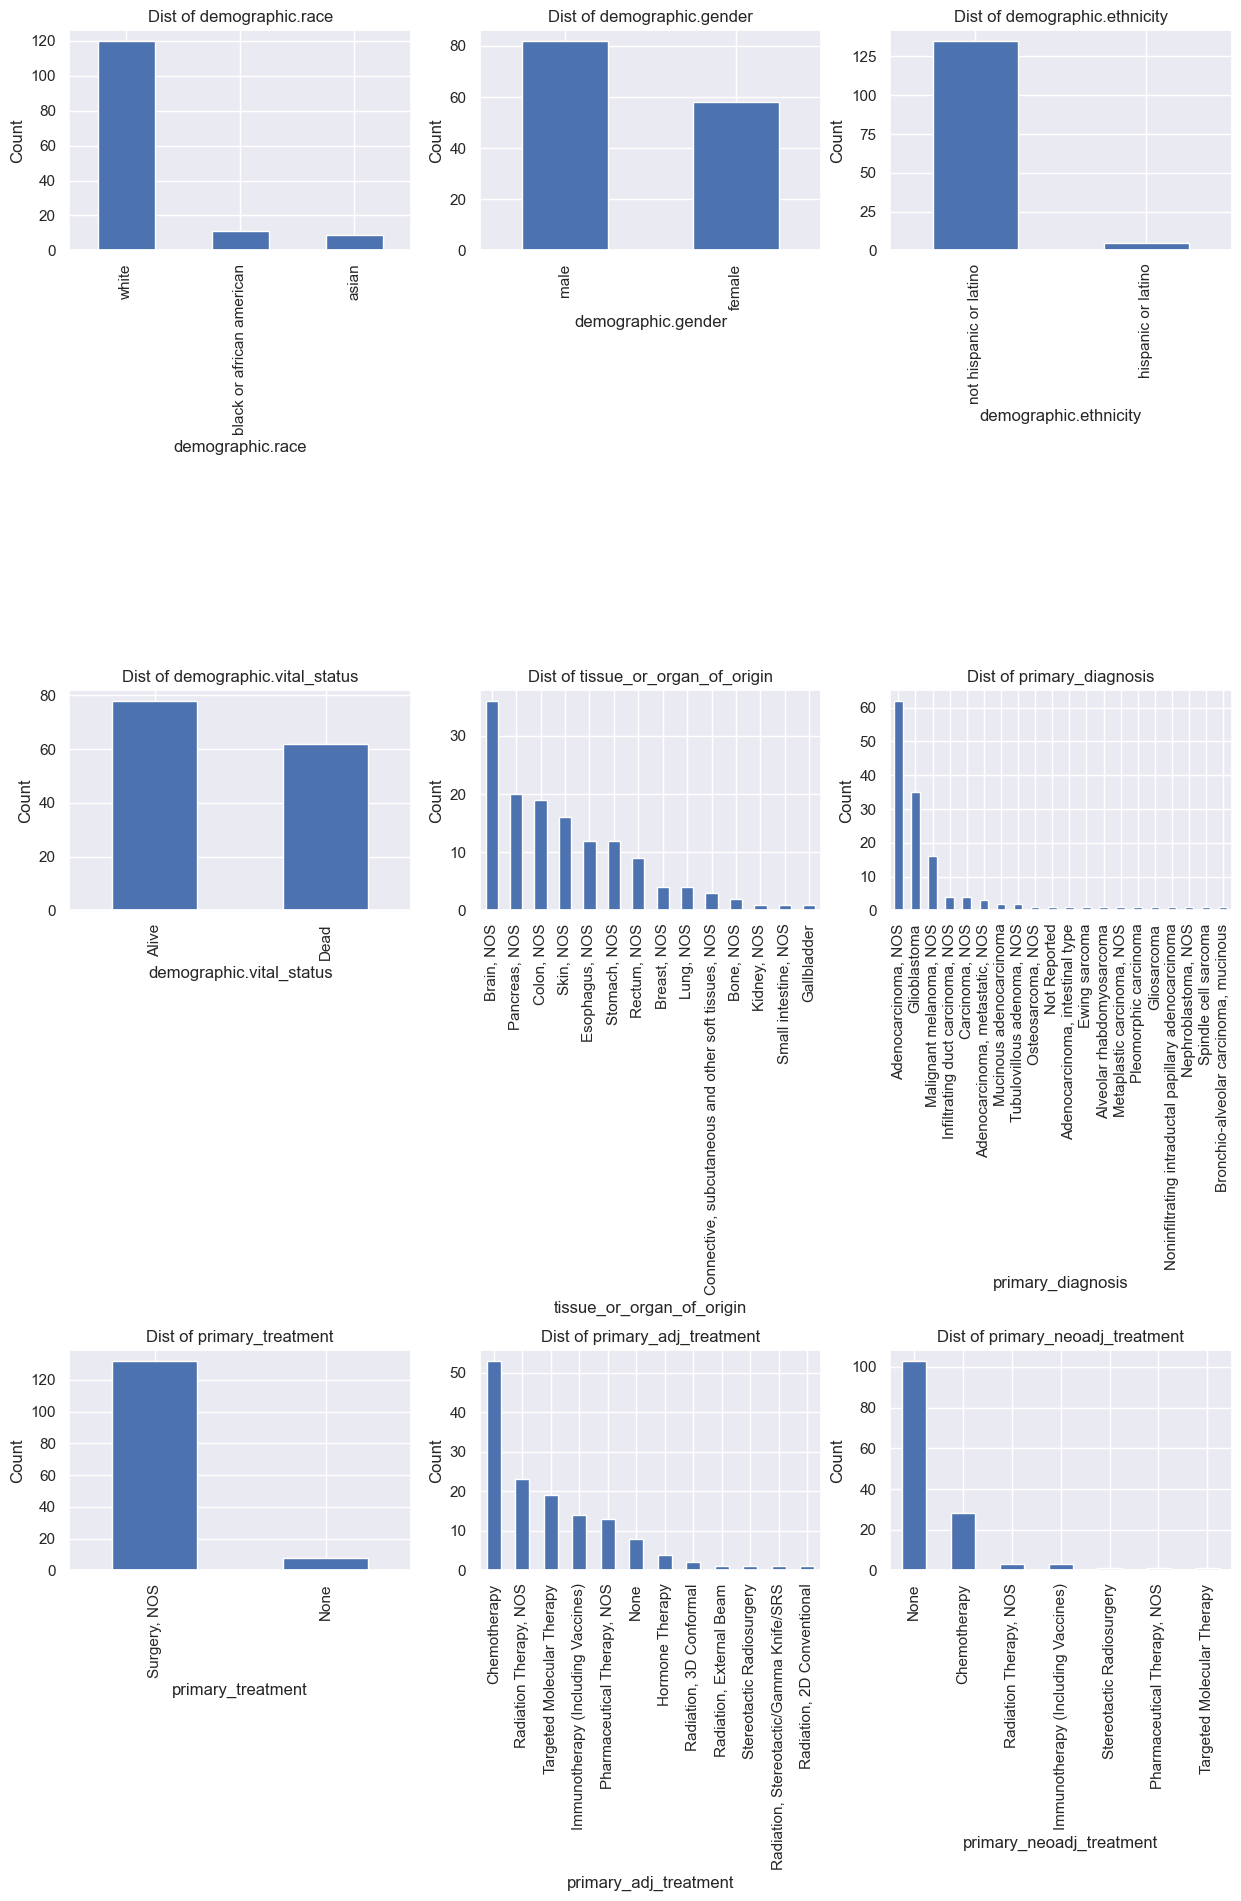

In [15]:
# understand feature distributions at a high level for categoric features
fig, axes = plt.subplots(3, 3, figsize=(15, 20))
plt.subplots_adjust(hspace=2)
i = 0
j = 0

for col in data_HCMI_CMDC.select_dtypes(include='object').columns[1:]:
    data_HCMI_CMDC[col].value_counts().plot(kind='bar', title=f'Dist of {col}', ylabel='Count', ax=axes[i][j])

    j += 1
    if j == 3:
        j = 0
        i += 1

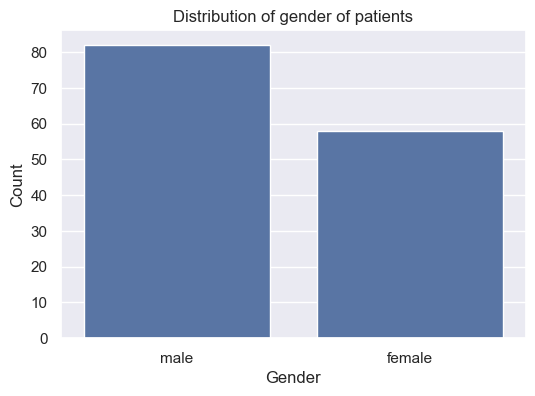

In [16]:
# creates a count plot showing how the gender among patients is distributed
plt.figure(figsize=(6, 4))
sns.countplot(data=data_HCMI_CMDC, x='demographic.gender')
plt.title('Distribution of gender of patients')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

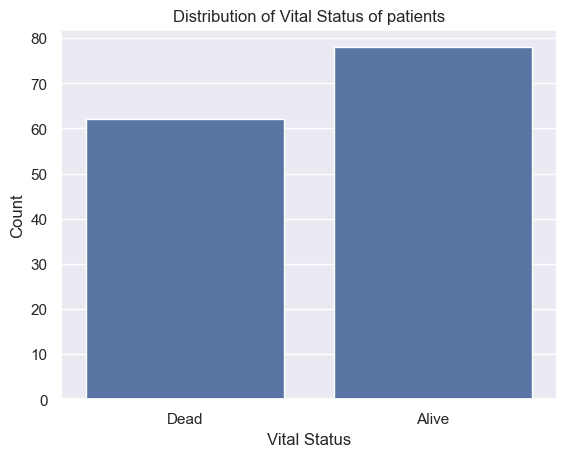

In [17]:
# creates a bar plot showing how the vital status among patients is distributed
sns.countplot(data=data_HCMI_CMDC, x='demographic.vital_status')
plt.title("Distribution of Vital Status of patients")
plt.xlabel("Vital Status")
plt.ylabel("Count")
plt.show()

In [18]:
import pandas as pd
import plotly.graph_objects as go
pd.set_option('future.no_silent_downcasting', True)

In [19]:
def _stacked(df, src, targ, *cols):
    """Extract column pairs, aggregate by the pairs, and stack the columns"""
    # Define columns
    columns = [src, targ, *cols]
    # Initialize list of pairs
    pairs = []
    # Pair up the columns to make groups of 2
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            pairs.append((columns[i], columns[j]))

    # Initialize list of aggregated dataframes
    concat_dfs = []
    # Iterate through extracted pairings and aggregate by the pairings to make a list of dataframes
    for pair in pairs:
        agg_df = df.groupby(list(pair), dropna=True).size().reset_index(name="Count")
        agg_df = agg_df[agg_df["Count"] > 3]
        agg_df.columns = ["src", "targ", "vals"]
        concat_dfs.append(agg_df)

    # Stack the list of aggregated dataframes
    stacked = pd.concat(concat_dfs, axis=0)
    return stacked

def _code_mapping(df, src, targ):
    """ Map labels in src and targ columns to integers """
    # Get the distinct labels
    labels = list(set(list(df[src]) + list(df[targ])))

    # Create a label->code mapping
    codes = range(len(labels))
    lc_map = dict(zip(labels, codes))

    # Substitute codes for labels in the dataframe
    df = df.replace({src: lc_map, targ: lc_map})

    return df, labels

def make_sankey(df, src, targ, *cols, vals=None, **kwargs):
    """
    Create a sankey figure
    df - Dataframe
    src - Source node column
    targ - Target node column
    vals - Link values (thickness)
    """
    # Aggregate and stack the columns
    stacked = _stacked(df, src, targ, *cols)
    
    # Map the source and target labels in the stacked DataFrame to integer codes
    df, labels = _code_mapping(stacked, "src", "targ")

    # Link data for the Sankey Diagram with the integer codes
    link = {'source': df["src"], 'target': df["targ"], 'value': df["vals"]}

    pad = kwargs.get('pad', 100)
    thickness = kwargs.get('thickness', 50)
    line_color = kwargs.get('line_color', 'black')
    line_width = kwargs.get('line_width', 1)

    node = {'label': labels, 'pad': pad, 'thickness': thickness, 'line': {'color': line_color, 'width': line_width}}
    sk = go.Sankey(link=link, node=node)
    fig = go.Figure(sk)

    width = kwargs.get('width', 1000)
    height = kwargs.get('height', 600)
    fig.update_layout(
        autosize=False,
        width=width,
        height=height)

    # Make Sankey
    sk = go.Sankey(link=link, node=node)
    fig = go.Figure(sk)
    return fig

In [20]:
fig = make_sankey(data_HCMI_CMDC, 'demographic.race', 'demographic.gender', 'primary_diagnosis')
fig.show()

Race, Gender, and Cancer Diagnosis Trends:
This sankey diagram gives a general idea of the cancer diagnoses common in a demographic. The data is filtered to only give categories with more 3 cases, so some minority demographics and diagnoses from the project are omitted from the diagram. 

In this clinical project, majority of the participants were white. White participant were mostly diagnosed with adenocarcionma and glioblastoma. Most males in the project were diagnosed with adenocarcionma, while most females were evenly diagnosed between adenocarcionma and glioblastoma. Most of the asian males and half of the Black and African American participants were diagnosed with adenocarcionma. Malignant melanoma was the least common diagnosis among the top 4 diagnoses in the project, and were diagnosed only the white participants. 

## Lin Reg Tools
Write some functions using numpy to implement and evaluate linear regression models

In [21]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

class Scaler:
    '''Standardizes data and saves the means / std deviations used to scale'''
    def __init__(self):
        self.means = []
        self.stds = []

    def fit(self, X):
        '''Fits the Scaler object with the provided data
        
        Args:
            X (np.ndarray, 1d or 2d array) - The data used to fit the Scaler
    
        Returns:
            None
        '''
        # reset means and standard deviations
        self.means = []
        self.stds = []

        # check for 1d or 2d then fit the Scaler
        if len(X.shape) == 1:
            self.means.append(X.mean())
            self.stds.append(X.std(ddof=1))

        elif len(X.shape) == 2:
            for col in X.T:
                self.means.append(col.mean())
                self.stds.append(col.std(ddof=1))

        else:
            raise ValueError("Input array must be either 1d or 2d")

    def transform(self, X):
        '''Scales the provided data, X, based on the fitted parameters mean and std
        
        Args:
            X (np.ndarray, 1d or 2d array) - The data to be transformed
    
        Returns:
            Xnew (np.ndarray, 1d or 2d array) - The transformed data
        '''
        # check for 1d or 2d then transform the data
        if len(X.shape) == 1:
            Xnew = (X - self.means[0]) / self.stds[0]

        elif len(X.shape) == 2:
            Xnew = np.zeros(X.shape)
            for i in range(X.shape[1]):
                Xnew[:, i] = (X[:, i] - self.means[i]) / self.stds[i]

        else:
            raise ValueError("Input array must be either 1d or 2d")
        
        return Xnew
    
    def fit_transform(self, X):
        '''Fits the Scaler based on the provided data, then transforms the provided data
        
        Args:
            X (np.ndarray, 1d or 2d array) - the data to be fitted and transformed

        Returns:
            Xnew (np.ndarray, 1d or 2d array) - the transformed data
        '''
        self.fit(X)
        Xnew = self.transform(X)

        return Xnew
    
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

class LinReg:
    '''
    Class for linear regression. Helps to calculate line of best fit and store the relevant information
    '''
    def __init__(self):
        self.m = None

    def fit(self, X, y):
        '''
        Fits a linear regression model based on the features X and target y. Adds a bias column to features X

        Args:
            X (np.ndarray, 1d or 2d array) - array containing feature data, no bias column
            y (np.ndarray, 1d array) - array containing target data

        Returns: None
        '''
        Xnew = add_bias_column(X)

        #self.m = np.matmul(np.linalg.inv(np.matmul(Xnew.T, Xnew)), np.matmul(Xnew.T, y))
        self.m = np.matmul(np.linalg.pinv(np.matmul(Xnew.T, Xnew)), np.matmul(Xnew.T, y))

    def predict(self, Xnew):
        '''Makes predictions for data Xnew based on the fitted linear regression model. Adds a bias column to Xnew
        
        Args:
            Xnew (np.ndarray, 1d or 2d array) - array containing feature data to make predictions on

        Return: 
            y_preds (np.ndarray, 1d array) - the predicted values from the linear regression model
        '''
        # and bias column and check that Xnew has the correct dimensionality
        Xnew = add_bias_column(Xnew)
        if Xnew.shape[1] != len(self.m):
            raise ValueError(f'Xnew has {Xnew.shape[1]} features, but must have the same number of features as was used to train the model: {len(self.m)}')

        # calculate the return values
        y_preds = Xnew @ self.m

        return y_preds


class Evaluator:
    '''
    Helps evaluate the assumptions and performance of a linear regression model
    '''
    def __init__(self, X, y, feat_names = None):
        '''Initilizes data to be used and linear regression model
        
        Args:
            X (np.ndarray, 1d or 2d array) - array containing feature data
            y (np.ndarray, 1d array) - array containing target data
            feat_names (list of str) - list of feature names in the same order they appear in X

        Returns:
            None
        '''
        # initialize the attributes of the Evaluator and fit the model
        self.X = X
        self.y = y
        self.feat_names = feat_names
        self.model = LinReg()
        self.model.fit(X, y)

        # calculated attributes
        y_preds = self.model.predict(X)
        self.residuals = y - y_preds
        self.mse = np.mean((y - y_preds) ** 2)
        self.r2 = r2_score(y, y_preds)

        # attributes to be initialized on method call
        self.sf_mse = None
        self.sf_r2 = None
        self.loocv_mse = None
        self.loocv_r2 = None

    def single_fold_cv(self, test_size):
        '''
        Finds the r2 and MSE for single fold cross validation

        Args:
            test_size (float) - the proportion of data to with-hold for the testing set

        Returns:
            mse (float) - the mean squared error from single fold cross validation
            r2 (float) - the r2 score from single fold cross validation
        '''
        # fit and make predictions
        Xtrain, Xtest, ytrain, ytest = train_test_split(self.X, self.y, test_size=test_size)
        model = LinReg()
        model.fit(Xtrain, ytrain)
        y_preds = model.predict(Xtest)

        # calculate MSE and r2
        self.sf_mse = np.mean((ytest - y_preds) ** 2)
        self.sf_r2 = r2_score(ytest, y_preds)

        return self.sf_mse, self.sf_r2

    def loo_cv(self):
        '''
        Finds the r2 and MSE using leave one out cross validation

        Args: None

        Returns:
            mse (float) - the mean squared error from leave one out cross validation
            r2 (float) - the r2 score from leave one out cross validation
        '''
        y_preds = np.empty(len(self.y))

        # loop through each observation
        for obs in range(len(self.y)):
            # the below excludes the single row/true y belonging to obs as well as the bias column
            trainX = np.concatenate((self.X[:obs], self.X[obs+1:]))
            trainy = np.concatenate((self.y[:obs], self.y[obs+1:]))

            # train the model and make prediction
            model = LinReg()
            model.fit(trainX, trainy)
            y_preds[obs] = model.predict(np.array([self.X[obs]]))[0]

        # calculate mse and r2
        self.loocv_mse = np.mean((self.y - y_preds) ** 2)
        self.loocv_r2 = r2_score(self.y, y_preds)

        return self.loocv_mse, self.loocv_r2

    def residual_plot(self, feat_name, feat_idx=None):
        '''
        Plots the residuals vs the designated feature for the model fitted on all data

        Args:
            feat_name (str) - the name of the feature to plot residuals against
            feat_idx (int) - the column index of the feature to plot residuals against. If no column index is specified,
            the index will be inferred from the feature name

        Return:
            None
        '''
        ft_idx = self.feat_names.index(feat_name)
        if feat_idx != None:
            ft_idx = feat_idx

        if len(self.feat_names) == 1:
            plt.scatter(self.X, self.residuals, alpha=0.5)
            plt.xlabel(feat_name)
            plt.ylabel('Residual')
            plt.title(f'Residual plot vs. {feat_name}')

        else:
            plt.scatter(self.X[:, ft_idx], self.residuals, alpha=0.5)
            plt.xlabel(feat_name)
            plt.ylabel('Residual')
            plt.title(f'Residual plot vs. {feat_name}')
        
    def order_plot(self):
        '''
        Plots the residuals vs order for the model fitted on all data

        Args: None

        Returns: None
        '''
        plt.scatter(range(len(self.X)), self.residuals, alpha=0.5)
        plt.xlabel('Index')
        plt.ylabel('Residual')
        plt.title('Residual Plot vs. Order')

    def residual_hist(self):
        '''
        Plots a histogram of the residuals

        Args: None

        Returns: None
        '''
        plt.hist(self.residuals)
        plt.xlabel('Residuals')
        plt.ylabel('Count')
        plt.title('Histogram of residuals')

    def summary(self):
        '''Prints a summary of the MSE and r2 scores for applied CV methods
        
        Args: None

        Returns: None
        '''
        print("All data MSE: ", self.mse)
        print("All data r2: ", self.r2)

        print("Single fold cv MSE: ", self.sf_mse)
        print("Single fold r2: ", self.sf_r2)

        print("LOOCV MSE: ", self.loocv_mse)
        print("LOOCV r2: ", self.loocv_r2)

## Lin Reg Tools example

In [22]:
# test / example use of Lin Reg tools

# create some dummy data
X = np.random.uniform(-1, 1, size=18).reshape(-1, 3) + np.arange(18).reshape(-1, 3)
y = np.arange(6)

# scale the data
scaler = Scaler()
X_scaled = scaler.fit_transform(X)

# create the model evaluator
evaluator = Evaluator(X_scaled, y, feat_names = ['test1', 'test2', 'test3'])

In [23]:
# see MSE and r2 for all CV types
evaluator.single_fold_cv(test_size=0.3)
evaluator.loo_cv()
evaluator.summary()

All data MSE:  0.012432308834448666
All data r2:  0.9957374941139033
Single fold cv MSE:  0.06992999942839784
Single fold r2:  0.9689200002540455
LOOCV MSE:  0.1296671146680743
LOOCV r2:  0.9555427035423745


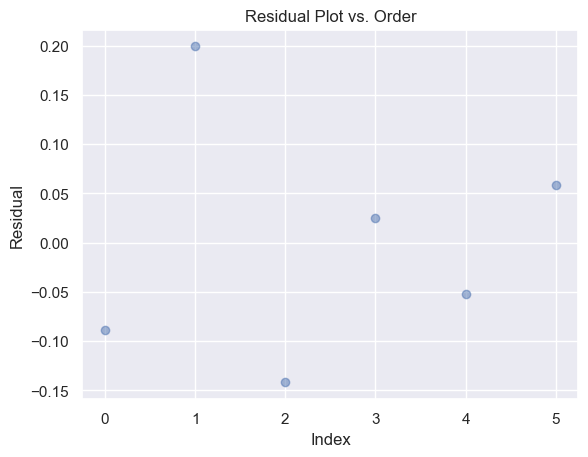

In [24]:
# plot order vs residuals
evaluator.order_plot()

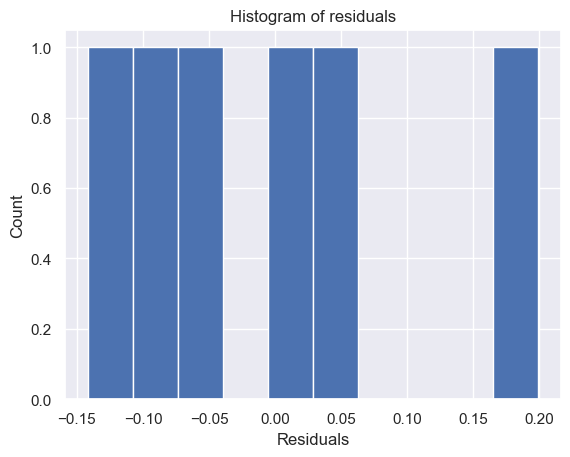

In [25]:
# plot histogram of residuals
evaluator.residual_hist()

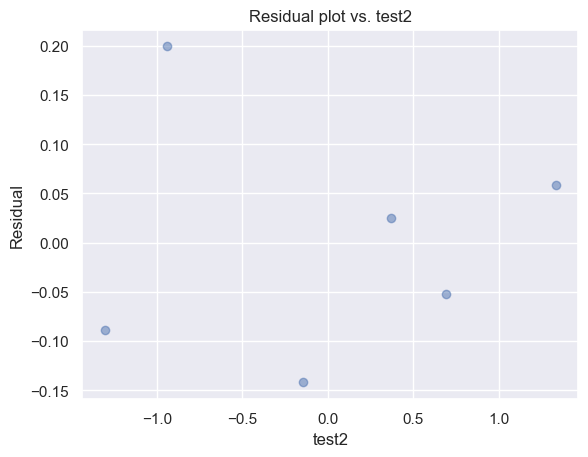

In [26]:
# plot residuals vs feature
evaluator.residual_plot(feat_name='test2', feat_idx=1)

# Linear Regression Implementation

We will start by trying to predict days to death (after diagnoses) using some the features we have available. This will contribute to our core research question of trying to predict patient survival outcomes based on demographic information, cancer information, and treatment information

In [27]:
# to predict days to death, we need to filter for those who died
dead_df = data_HCMI_CMDC[data_HCMI_CMDC["demographic.vital_status"] == "Dead"]
#dead_df.head()

### Candidate Model 1

In [28]:
# model with feature: age at diagnoses
X = dead_df["age_at_diagnosis"].values
y = dead_df["demographic.days_to_death"].values

# adds the bias column, fits the model
evaluator = Evaluator(X, y, ["age_at_diagnosis"])

# R2 and MSE for cross validated data and  full data
evaluator.single_fold_cv(test_size=0.3)
evaluator.loo_cv()
evaluator.summary() # model using only age at diagnosis does not work well :(

All data MSE:  186281.97382328755
All data r2:  0.0021545754289262753
Single fold cv MSE:  106172.99786225359
Single fold r2:  -0.3459790554066944
LOOCV MSE:  198917.8171476322
LOOCV r2:  -0.06553108512111239


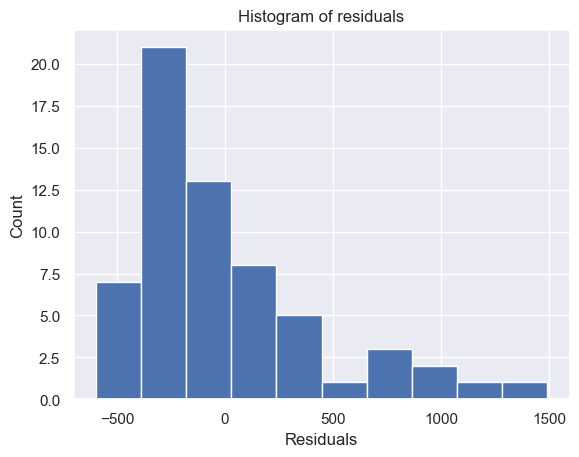

In [29]:
# create some plots to check assumptions
evaluator.residual_hist()

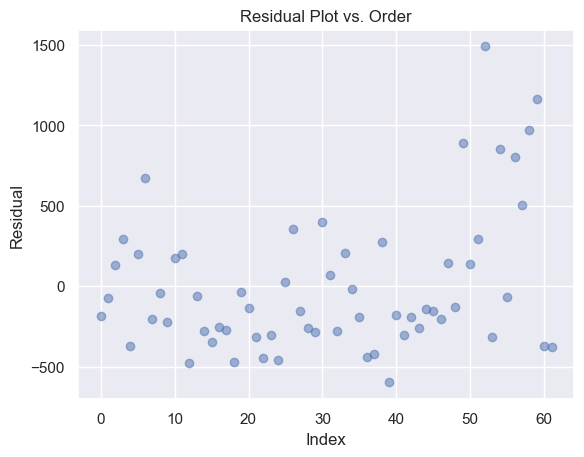

In [30]:
evaluator.order_plot()

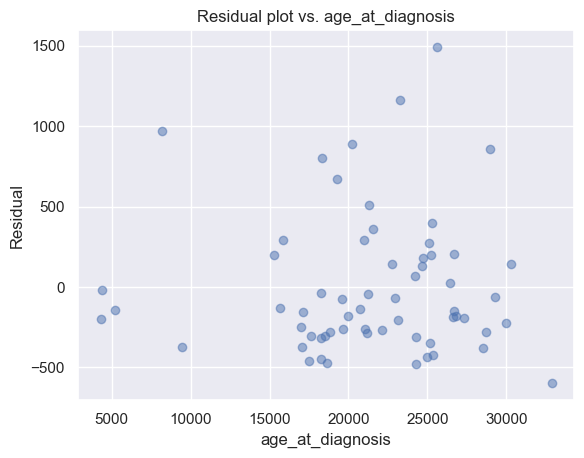

In [31]:
evaluator.residual_plot(feat_name='age_at_diagnosis')

### Analysis of model 1
The model doesn't seem to be performing well. To start, we see poor performance across our MSE and $R^2$ values. The $R^2$ values are very low, indicating that the features are not accounting for variation in the target variable. Since we have a small dataset, the LOOCV $R^2$ will be the best indicator of performance, so we'll pay the most attention to that value moving forward. For the residual historgram, it's clearly skewed right, meaning that the model is consistently over predicting days to death. THe order plot shows a clear pattern, meaning we may need to add additional features to account for auto-correlation among the observations. Based on the order plot, it seems for most records we over predict, but for the last few records we under predict. Finally, the residual plot vs the age_at_diagnoses features seems to be the best of all the plots we've looked at. We still see the clear over-predicting, but there isn't an obvious patten indicating a clear issue with linearity. There is some fanning indicating homoscedasticity might be violated. Since we are dealing with issues primarily on auto-correlation and constant variance, we will start by adding more features

### Candidate Model 2

In [32]:
# model with features: age at diagnoses and total times treated (all the numeric features)
# scaled numeric X values
times_treated = dead_df["total_times_treated"].values.reshape(-1, 1)
age_diagnosed = dead_df["age_at_diagnosis"].values.reshape(-1,1)

scaler = Scaler()
scaled_times = scaler.fit_transform(times_treated)
scaled_age = scaler.fit_transform(age_diagnosed)

X_numeric = np.concatenate([scaled_age, scaled_times], axis = 1)

# adds the bias column, fits the model
eval_numeric = Evaluator(X_numeric, y, feat_names=['age_at_diagnosis', 'total_times_treated'])

eval_numeric.loo_cv()
eval_numeric.single_fold_cv(test_size=0.3)
eval_numeric.summary() #stil not looking good

All data MSE:  181486.88486669754
All data r2:  0.02784013950977282
Single fold cv MSE:  206113.20333114904
Single fold r2:  -0.813598717049594
LOOCV MSE:  197568.4148872833
LOOCV r2:  -0.05830282334269521


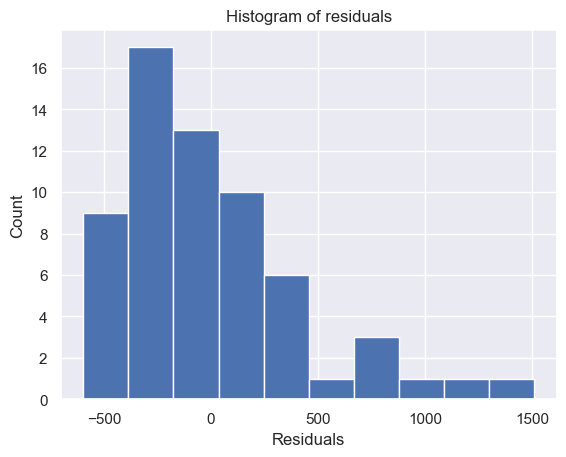

In [33]:
# create some plots to check assumptions
eval_numeric.residual_hist()

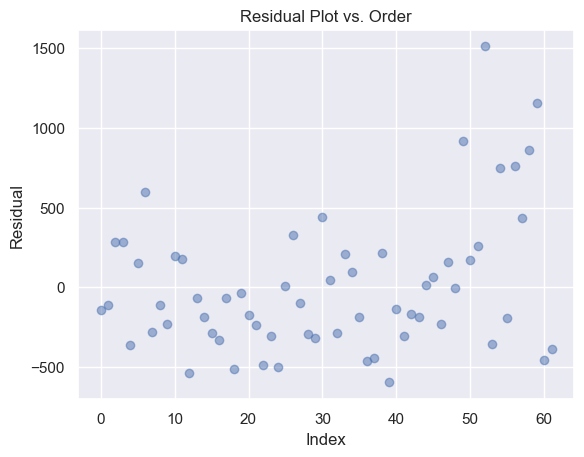

In [34]:
eval_numeric.order_plot()

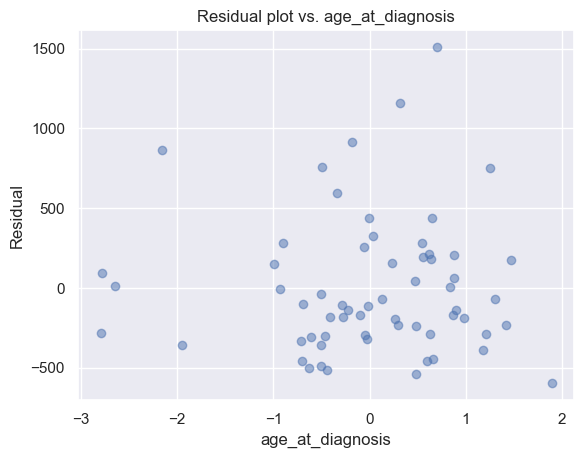

In [35]:
eval_numeric.residual_plot(feat_name='age_at_diagnosis')

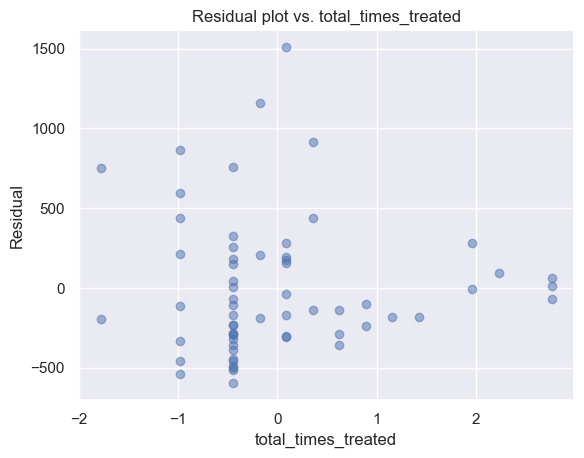

In [36]:
eval_numeric.residual_plot(feat_name='total_times_treated')

### Analysis of model 2
It does not appear that adding the additional numeric features was able to address some of the concerns from our initial candidate model. Although there was some improvement, we still see poor performance from our MSE and LOOCV $R^2$ values. The residual histogram is still skewed right, and there is still a pattern in our order plot, pointing to issues with auto-correlation and over predicting. Looking at the two residual vs feature plots, these are still looking ok. There is a relatively random scattering of points, so a clear issue with linearity is not jumping out, but there may be some indication of slight fanning which could point to an issue with homoscedasticity. Overall, this model did not see much improvement over the first candidate model

### Candidate model 3

In [37]:
# model with feature: primary_adj_treatment
# make categorical to binary
treatment_dummies = pd.get_dummies(dead_df, columns=['primary_adj_treatment'], drop_first=True)
new_cols = treatment_dummies.columns.difference(dead_df.columns)
treatmentX = np.array(treatment_dummies.iloc[:, - len(new_cols) :]).astype('int')

eval_cat = Evaluator(treatmentX, y)

eval_cat.single_fold_cv(test_size=0.3)
eval_cat.loo_cv()
eval_cat.summary() # better with all the data, but worse with cross validation (possibly overfitting?)

All data MSE:  142917.57324950056
All data r2:  0.2344420470168571
Single fold cv MSE:  253988.9822807015
Single fold r2:  -0.885649787133518
LOOCV MSE:  223711.8203779464
LOOCV r2:  -0.19834362823727614


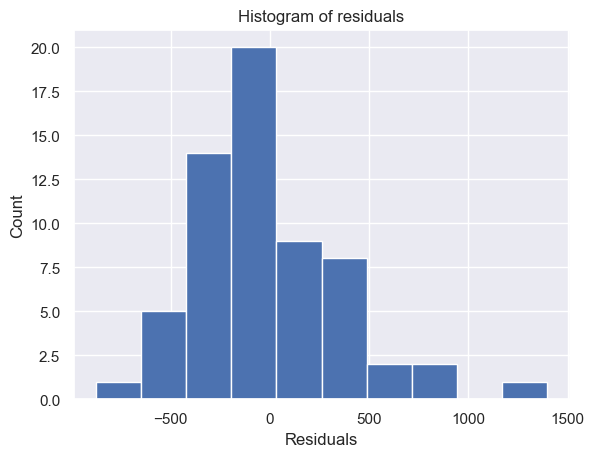

In [38]:
eval_cat.residual_hist()

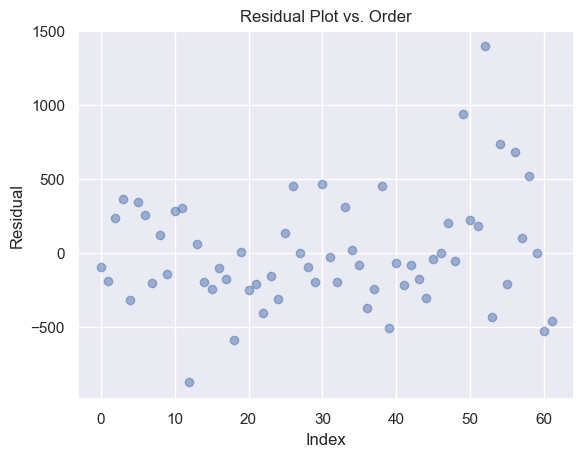

In [39]:
eval_cat.order_plot()

### Model 3 analysis
Even though it doesn't make much sense to fit a regression model using only dummy variables, we can get some interesting insights from this model. It seems by including our categorical variables, this can assist us in addressing some of the violated assumptions. Both the histogram of residuals and the order plot looks a lot better compared to the previous candidate model. The histogram is much closer to an approximately normal distribution, and the order plot is more evenly scatter with less of an upward sweep at the end

### Feature Analysis
Since we have many categorical features, and some of those categorical features can take on many values, it would create a lot of columns if we included dummy variables for every single categorical feature. Additionally, we have a relatively small data set here at only 62 records. Because of the small dataset, it'll be especially important to avoid a large number of features, otherwise we will be very likely to run into issues with overfitting and multi-colinearity. Below we will conduct a feature analysis to determine which features may be most predictive of the target and should be included in the analysis

In [40]:
# get categorical features
X = dead_df.drop(columns=["demographic.days_to_death", "id"]) 
cat_cols = X.select_dtypes(exclude=["number"]).columns

# categorical to binary
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# target variable
y = dead_df["demographic.days_to_death"]

# correlation matrix with target
corr_w_target = X_encoded.corrwith(y)

# set a threshold
relevant_features = corr_w_target[abs(corr_w_target) > 0.3]
print("Relevant Features:")
print(relevant_features)

Relevant Features:
tissue_or_organ_of_origin_Skin, NOS                            0.569415
primary_diagnosis_Malignant melanoma, NOS                      0.569415
primary_adj_treatment_Radiation, 3D Conformal                  0.346926
primary_neoadj_treatment_Immunotherapy (Including Vaccines)    0.445901
primary_neoadj_treatment_Targeted Molecular Therapy            0.346926
dtype: float64


In [41]:
X = dead_df.drop(columns=["demographic.days_to_death", "id"])  # features
X = X.select_dtypes(include=["number"]) # numeric features

y = dead_df["demographic.days_to_death"]  # target 

correlation_with_target = X.corrwith(y)
print("Correlation with Target:")
print(correlation_with_target)

Correlation with Target:
age_at_diagnosis       0.046417
total_times_treated   -0.166749
dtype: float64


### Candidate Model 4
Based on the results of our feature analysis, we will include the columns total_times_treated, primary_adj_treatment, tissue_or_organ_of_origin, primary_diagnoses, and primary_neo_adj_treatment. Based on the results of our feature analyis, these features were most strongly correlated with our target

In [42]:
# categorical columns to binary 
categorical_dummies = pd.get_dummies(dead_df, columns=['primary_adj_treatment', 'tissue_or_organ_of_origin', 
                                                       'primary_diagnosis', 'primary_neoadj_treatment'], drop_first=True)
# made them into array of ints
new_cols = categorical_dummies.columns.difference(dead_df.columns)
catX = np.array(categorical_dummies.iloc[:, - len(new_cols) :]).astype('int')

# do not need to scale since only numeric feature
times_treated = dead_df["total_times_treated"].values.reshape(-1, 1)

# concat numerical and binary features
X_relevant = np.concatenate([times_treated, catX], axis = 1)

# add bias column, fit, evaluate performance
feats = ['total_times_treated','primary_adj_treatment', 'tissue_or_organ_of_origin',
         'primary_diagnosis', 'primary_neoadj_treatment']
eval = Evaluator(X_relevant, y, feat_names= feats)

eval.single_fold_cv(test_size=0.3)
eval.loo_cv()
eval.summary() #better for all data... but still overfitting

All data MSE:  64590.101235785056
All data r2:  0.6540140966519359
Single fold cv MSE:  126652.54519761422
Single fold r2:  0.38271847052040797
LOOCV MSE:  160132.85918230898
LOOCV r2:  0.14222596218499162


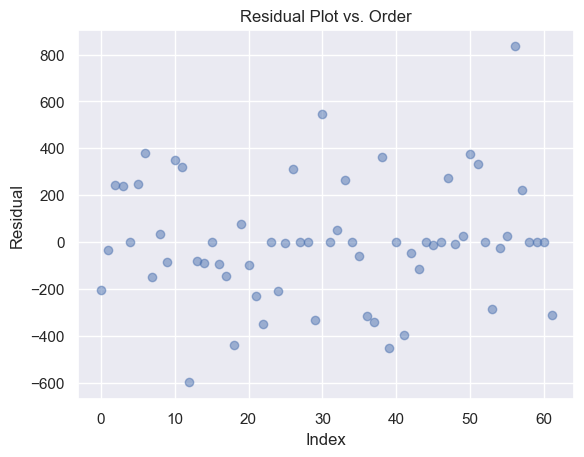

In [43]:
# plot order vs residuals
eval.order_plot()

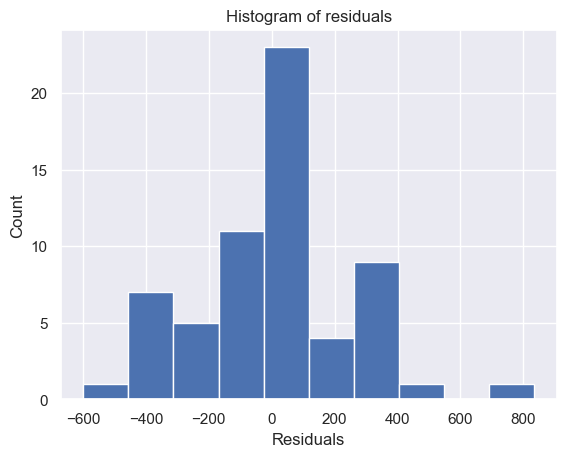

In [44]:
# plot histogram of residuals
eval.residual_hist()

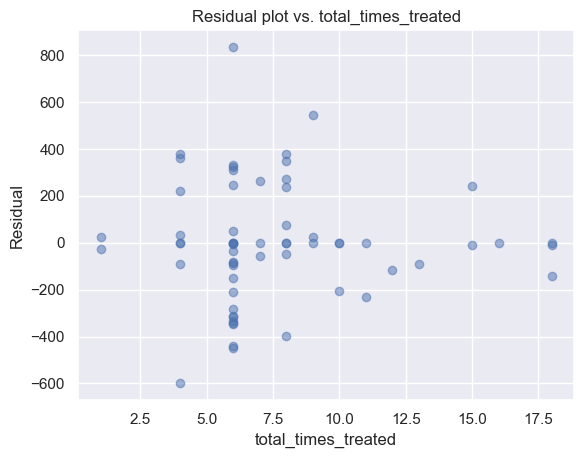

In [45]:
# plot residuals vs feature (only for numerical features)
eval.residual_plot(feat_name = "total_times_treated")

In [46]:
X_relevant.shape

(62, 31)

### Model 4 Analysis
Overall, this looks like our best model yet. First, addressing our assumptions, we saw some great improvement. The residual histogram looks approximately normal (perhaps still slightly sweked right, but definitely pretty good), which is great to see. Additionally, the order plot looks much much better with a primarily random scattering of points around 0, so it appears that we've solved the auto-correlation problem. It appears there may be an outlier here, but overall this order plot looks very good. On the residual plot of our numeric feature, total_times_treated, we continue to see a mostly random scattering of points around 0, which is good for the linearity assumption, although there does still appear to be some fanning, so homoscedasticity may still be a concern.

Additionally, We see a big improvement in our MSE and $R^2$ values across the board. One important note is that our LOOCV $R^2$ value is much lower than the full data $R^2$ at 0.14 compared to 0.65, respectively. This points to an issue with overfitting and that our model may have a hard time generalizing to new data. One important observation as well is that even after our feature analysis to reduce the features used, we still ended with 31 features compared to 62 records of data. This is likely a large contributor to our over-fitting, and may even pose issues with multi-colinearity.

Even though this model performs much better, as next steps to further refine our proof of concept we should address the over-fitting and potential multi-colinearity issues. To start, we should test for multi-colinearity by fitting the data with columns in a different order and seeing if this affects the results. To address over-fitting and the chances of multi-colinearity, we should reduce our number of features. One way to do this is to create an "Other" group for the high caridnality categorical features. This way we can group the less common categories into the "Other" bucket which will help reduce the number of dummy variables created while hopefully having a minimal impact on predictive power. In this case, it does not make sense to use PCA since this relies on the covariance matrix which cannot be meaningfully interpreted for categorical features.

### Candidate Model 5
In this model we will attempt to address the over-fitting and potential for multi-colinearity as identified from our analysis of candidate model 4 by reducing the number of features for the model. We will do this by creating an "Other" bucket to reduce the number of categories, and therefore dummy columns, for high cardinality categorical features

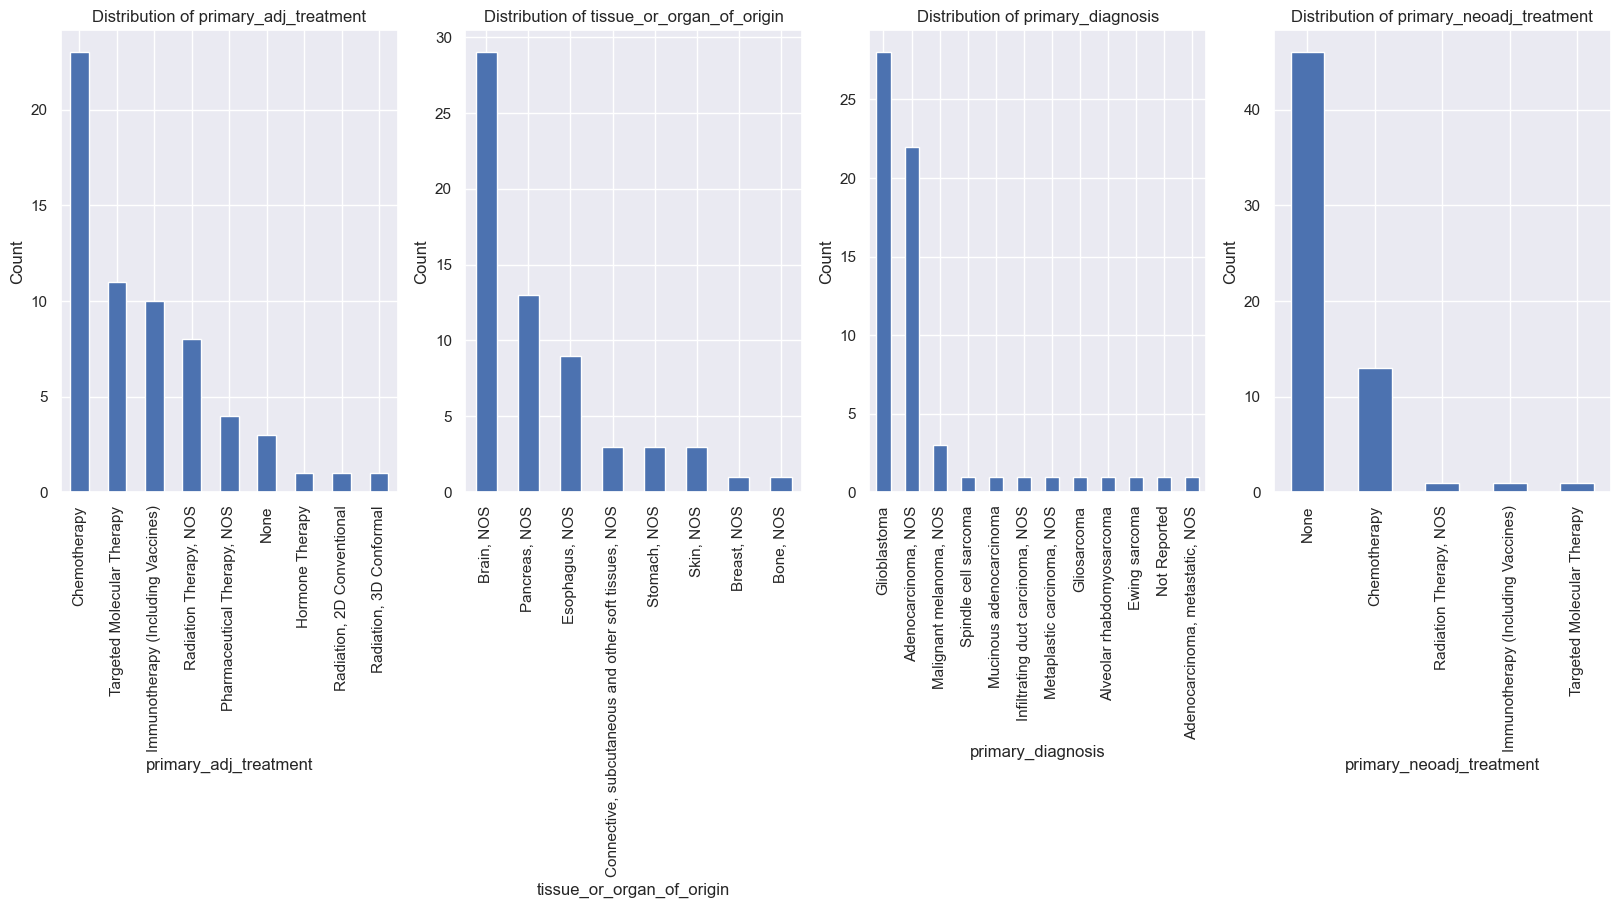

In [47]:
# analyze the category distribution of the categorical features being used
col_names = ['primary_adj_treatment', 'tissue_or_organ_of_origin', 'primary_diagnosis', 'primary_neoadj_treatment']
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
for col, ax in zip(col_names, axes):
    dead_df[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {col}')

In [48]:
# our features can be adequetly described by the 3 most common observations, except primary_adj_treatment, which should use 4
dead_df_red = dead_df.copy(deep=True)

# replace less common observations with "other"
for col in col_names[1:]:
    top_3_vals = dead_df_red[col].value_counts().index[:3]
    dead_df_red[col] = dead_df_red[col].apply(lambda x: x if x in top_3_vals else 'Other')

top_4_vals = dead_df_red['primary_adj_treatment'].value_counts().index[:4]
dead_df_red['primary_adj_treatment'] = dead_df_red['primary_adj_treatment'].apply(lambda x: x if x in top_4_vals else 'Other')


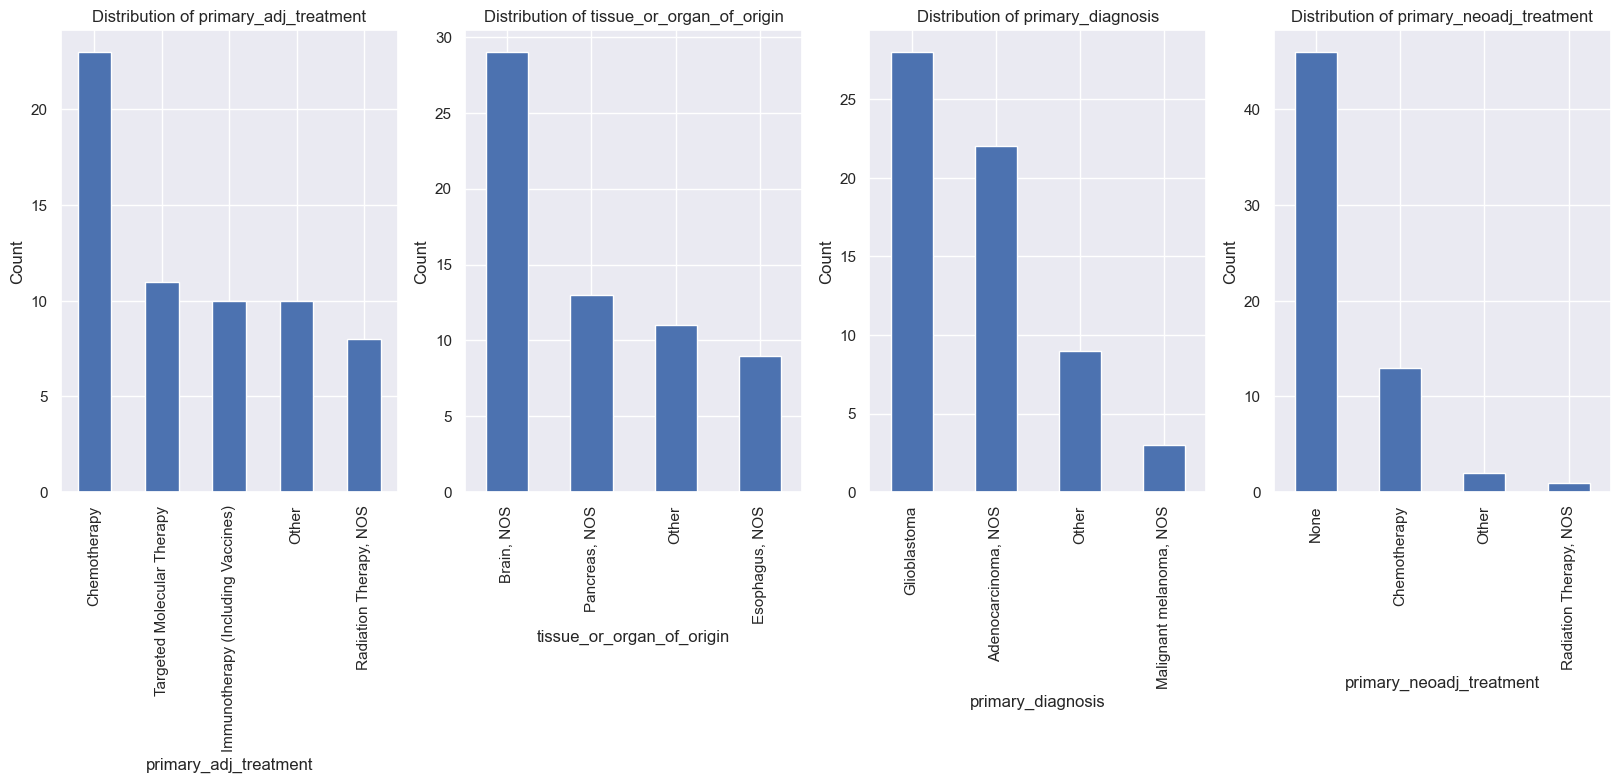

In [49]:
# check that the data transformation worked 
col_names = ['primary_adj_treatment', 'tissue_or_organ_of_origin', 'primary_diagnosis', 'primary_neoadj_treatment']
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
for col, ax in zip(col_names, axes):
    dead_df_red[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {col}')

In [50]:
# now can create the dataset with reduced columns

# categorical columns to binary 
categorical_dummies = pd.get_dummies(dead_df_red, columns=['primary_adj_treatment', 'tissue_or_organ_of_origin', 
                                                       'primary_diagnosis', 'primary_neoadj_treatment'], drop_first=True)
# made them into array of ints
new_cols = categorical_dummies.columns.difference(dead_df_red.columns)
catX = np.array(categorical_dummies.iloc[:, - len(new_cols) :]).astype('int')

# do not need to scale since only numeric feature
times_treated = dead_df_red["total_times_treated"].values.reshape(-1, 1)

# concat numerical and binary features
X_relevant = np.concatenate([times_treated, catX], axis = 1)

# add bias column, fit, evaluate performance
feats = ['total_times_treated','primary_adj_treatment', 'tissue_or_organ_of_origin',
         'primary_diagnosis', 'primary_neoadj_treatment']
eval_less_cat = Evaluator(X_relevant, y, feat_names= feats)

eval_less_cat.single_fold_cv(test_size=0.3)
eval_less_cat.loo_cv()
eval_less_cat.summary()

All data MSE:  84627.38895539736
All data r2:  0.5466815648912606
Single fold cv MSE:  121438.82250012289
Single fold r2:  0.3621067908807938
LOOCV MSE:  137030.4614062566
LOOCV r2:  0.2659771842937031


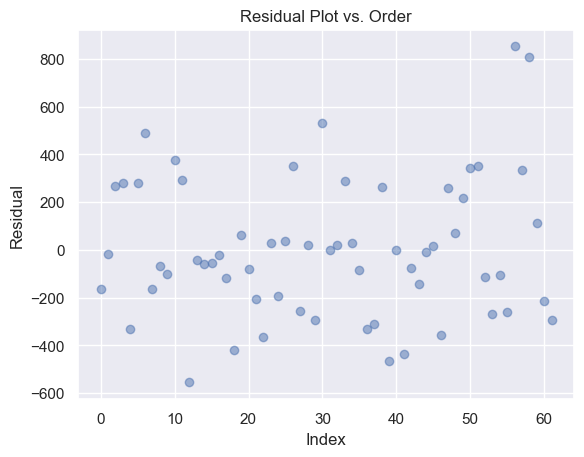

In [51]:
# plot order vs residuals
eval_less_cat.order_plot()

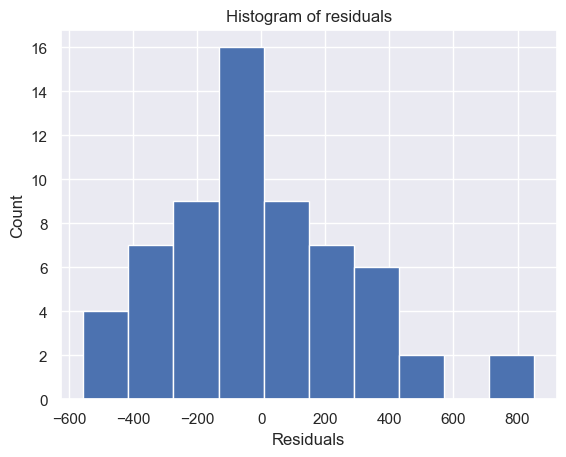

In [52]:
# plot histogram of residuals
eval_less_cat.residual_hist()

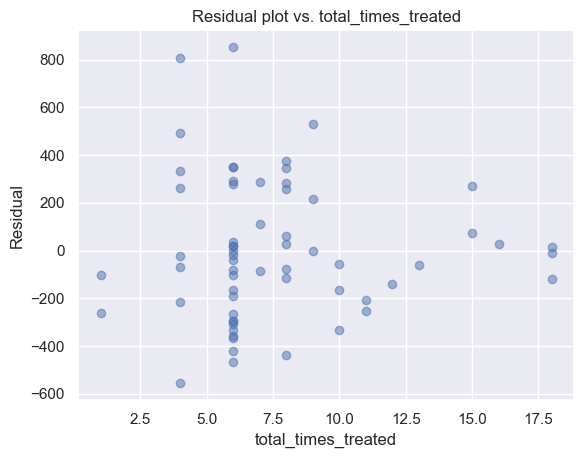

In [53]:
# plot residuals vs feature (only for numerical features)
eval_less_cat.residual_plot(feat_name = "total_times_treated")

In [54]:
# fit model with data in reverse order and check that weights are equal to check for multi-colinearity
eval_less_cat2 = Evaluator(np.fliplr(X_relevant), y, feat_names= feats)
eval_less_cat2.model.m

assert np.allclose(eval_less_cat.model.m[1:], eval_less_cat2.model.m[:0:-1])

In [55]:
X_relevant.shape

(62, 14)

### Model 5 Analysis
Our model appears to still be doing pretty well on our assumptions. The residual histogram still looks approximately normal, and the order plot is a primarily random scatter around 0. There appears to be two outliers which are not handeled as well in this model, but this is likely going to be a necesarry trade-off as we attempt to improve over-fitting. The residual plot of our numeric features looks very similar to our last model, so linearity doesn't seem to be an issue but homoscedasticity is still a concern due to the fanning.

In this model our overall $R^2$ score for the model fit on all data dropped from 0.65 to 0.55. However, this is generally expected considering we used less features and actually is not too severe of a drop. From a positive note, we did see the LOOCV $R^2$ value increase from 0.14 to 0.27, meaning we did have some success addressing overfitting. Another positive note is that we checked for multi-colinearity, and did not have an issue with this model. However, overfitting still appears to be an issue considering there is still quite a large gap between the full data $R^2$ score (0.55) and the LOOCV $R^2$ score (0.27).

In terms of next steps, our main focus should be addressing over-fitting while maintaining as high performance as possible. It seems clear that reducing the number of features helps over-fitting, but we also want to remove features in a way that maintains high performance. In our original feature analysis, we attempted to identify the most important features by looking at correlations between features and the target. However, this was not a best practice since correlation cannot be meaningfully interepreted for categorical features. Since we have a relatively small number of features and data points, we can "brute force" our way to the best combination, by checking all the combinations of features and seeing which has the highest LOOCV $R^2$ score. Before we do this, we can preprocess our remaining categorical features in the same way we did for the selected features of this model, creating "Other" buckets to reduce the number of dummy columns created when they are introduced into the model. We should also scale our numeric features since they may both be included in the model.

### Candidate Model 6

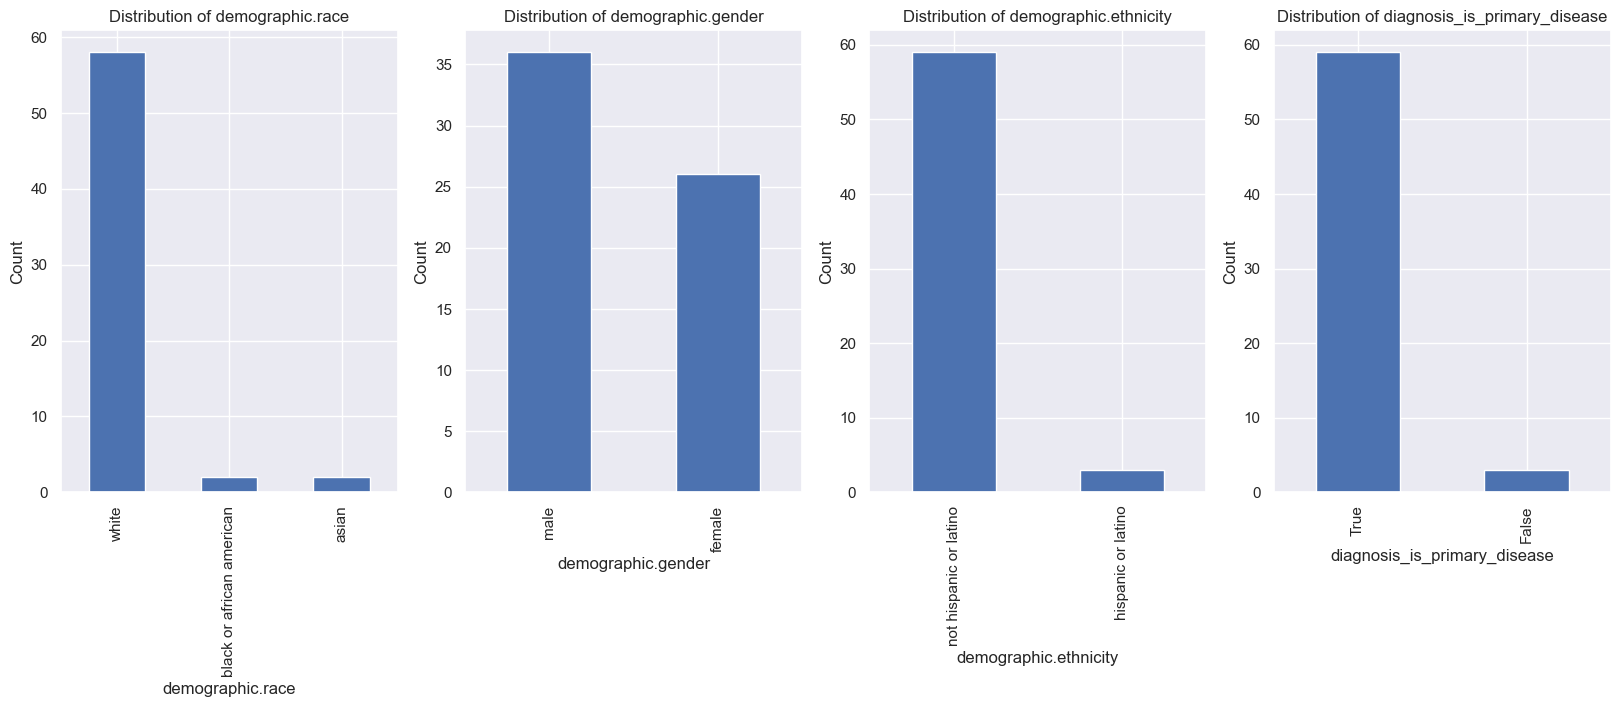

In [56]:
# check the distributions for remaining categorical features
col_names = ['demographic.race', 'demographic.gender', 'demographic.ethnicity', 'diagnosis_is_primary_disease',
             'primary_treatment']
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
for col, ax in zip(col_names, axes):
    dead_df_red[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {col}')

Other categorical columns are not high cardinality, so the "Other" column will not be necesarry

In [57]:
# create some polynomial features and an interaction term to try out
dead_df_red['total_times_treated^2'] = dead_df_red['total_times_treated'] ** 2
dead_df_red['age_at_diagnosis^2'] = dead_df_red['age_at_diagnosis'] ** 2
dead_df_red['times_treated_x_age_diagnosis'] = dead_df_red['total_times_treated'] * dead_df_red['age_at_diagnosis']

# scale numeric features, convert boolean column to 1s and 0s
scaler = Scaler()
dead_df_red['total_times_treated'] = scaler.fit_transform(dead_df_red['total_times_treated'].values)
dead_df_red['age_at_diagnosis'] = scaler.fit_transform(dead_df_red['age_at_diagnosis'].values)
dead_df_red['total_times_treated^2'] = scaler.fit_transform(dead_df_red['total_times_treated^2'].values)
dead_df_red['age_at_diagnosis^2'] = scaler.fit_transform(dead_df_red['age_at_diagnosis^2'].values)
dead_df_red['times_treated_x_age_diagnosis'] = scaler.fit_transform(dead_df_red['times_treated_x_age_diagnosis'].values)
dead_df_red['diagnosis_is_primary_disease'] = dead_df_red['diagnosis_is_primary_disease'].astype(float)


In [58]:
# create models with all combinations of features
# all models must at least include total_times_treated, since it doesn't make sense to do regression with only categorical features
possible_feats = dead_df_red.drop(columns=['demographic.days_to_death', 'total_times_treated']).columns[1:]

models = []

for i in range(1, len(possible_feats)+1):
    for feats in combinations(possible_feats, r=i):
        X = pd.get_dummies(dead_df_red[['total_times_treated'] + list(feats)], drop_first=True, dtype=float).values
        model = Evaluator(X, y, feat_names = ['total_times_treated'] + list(feats))
        model.loo_cv()
        models.append(model)

In [59]:
# find the model with the best LOOCV R^2 score
best_model = max(models, key=lambda x:x.loocv_r2)

best_model.single_fold_cv(test_size=0.3)
best_model.summary()
print('Features: ', best_model.feat_names)

All data MSE:  72545.07100391542
All data r2:  0.611402189429715
Single fold cv MSE:  129046.57371735404
Single fold r2:  0.1405661786627992
LOOCV MSE:  115081.79575507378
LOOCV r2:  0.38354827904841793
Features:  ['total_times_treated', 'demographic.race', 'demographic.ethnicity', 'primary_diagnosis', 'primary_treatment', 'primary_neoadj_treatment', 'total_times_treated^2']


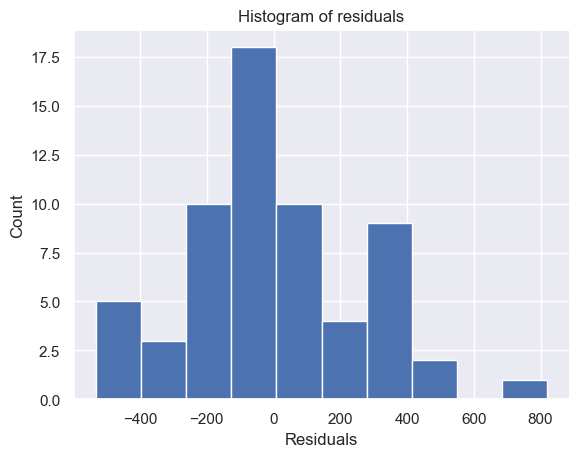

In [60]:
best_model.residual_hist()

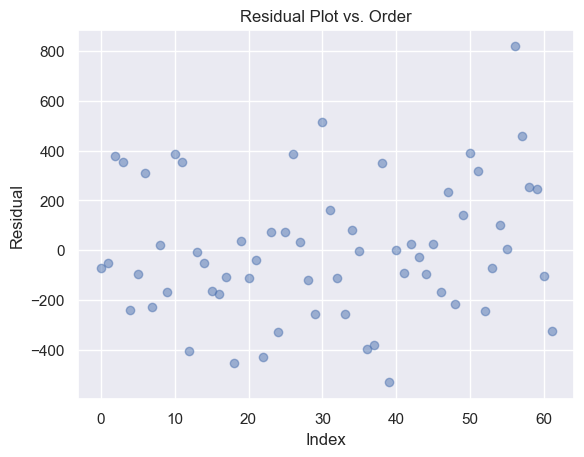

In [61]:
best_model.order_plot()

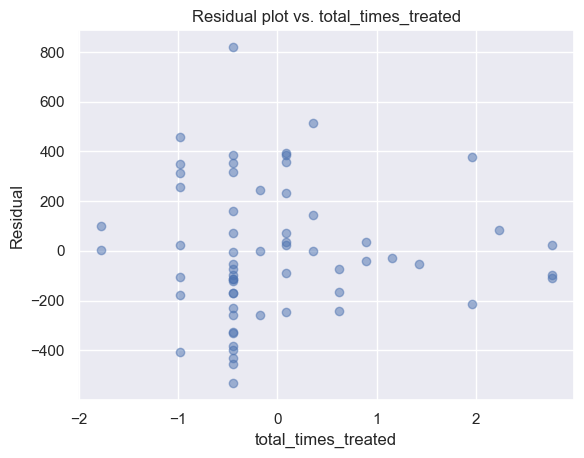

In [62]:
best_model.residual_plot(feat_name='total_times_treated')

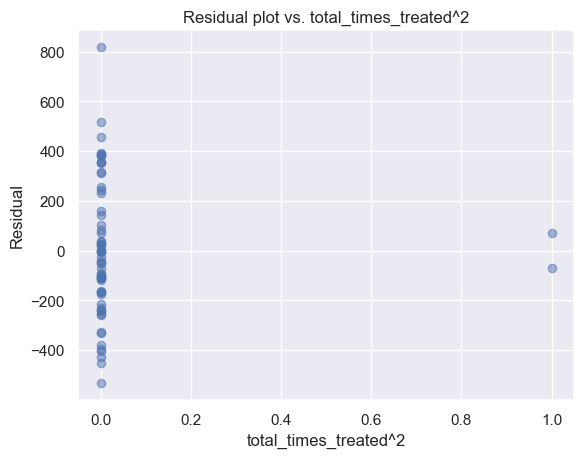

In [63]:
best_model.residual_plot(feat_name='total_times_treated^2', feat_idx=2)

In [64]:
best_model.X.shape

(62, 12)

In [65]:
# fit model with data in reverse order and check that weights are equal to check for multi-colinearity
feats = best_model.feat_names

X = pd.get_dummies(dead_df_red[feats], drop_first=True, dtype=float).values
model = Evaluator(X, y)
model2 = Evaluator(np.fliplr(X), y)

assert np.allclose(model.model.m[1:], model2.model.m[:0:-1])

In [66]:
# model weights
for feat, weight in zip(pd.get_dummies(dead_df_red[feats], drop_first=True, dtype=float).columns, model.model.m):
    print(feat, ': ' + ((50 - len(feat)) * ' '), round(weight, 2))

total_times_treated :                                 1084.07
total_times_treated^2 :                               -252.19
demographic.race_black or african american :          218.5
demographic.race_white :                              -901.44
demographic.ethnicity_not hispanic or latino :        -673.83
primary_diagnosis_Glioblastoma :                      -303.44
primary_diagnosis_Malignant melanoma, NOS :           113.76
primary_diagnosis_Other :                             960.92
primary_treatment_Surgery, NOS :                      60.39
primary_neoadj_treatment_None :                       278.15
primary_neoadj_treatment_Other :                      24.54
primary_neoadj_treatment_Radiation Therapy, NOS :     1009.15


### Model 6 Analysis

For this model, our small dataset enabled us to use "brute force" to find the best combination of features to reduce over-fitting while maintaining high performance. As a minimum requirement, 'total_times_treated' was a required feature since it doesn't make sense to perform a regression with only categorical features. We also added as candidate features some polynomial features and an interaction term, in case they may help improve performance or address some of the issues we've seen with heteroscadasticity. After the analysis was complete, the selected features were: 'total_times_treated', 'demographic.race', 'demographic.ethnicity', 'primary_diagnosis', 'diagnosis_is_primary_disease', 'primary_treatment', 'primary_neoadj_treatment', 'total_times_treated^2'.

This model still appears to be doing well on our assumptions. The residual histogram looks a bit worse (very slightly skewed right), but is still overall approximately normal, and this is the least important assumption. The residual plot still looks pretty good with a mostly random scattering of points around 0. On the residual plots of 'total_times_treated' and 'total_times_treated^2' linearity doesn't appear to be an issue, although we are still struggling to address the issue with heteroscadasticity, since there is still some fanning in these residual plots. We should also note that since we have quite a small number of data points, the fanning pattern may be exaggerated. There is the widest spread in the area with the most observations, and then a smaller spread towards the extreme where there are less observations. We may simply not have enough data points at the extremes to capture the true variation in residuals which could lead to the exaggerated fanning pattern. We also checked for multi-colinearity by fitting the data with features in a different order and verifying the weights were still the same

For this model, we saw the best performance on our LOOCV $R^2$ score and the most improvement towards addressing over-fitting. Our full data $R^2$ was 0.61, compared to the LOOCV $R^2$ of 0.38. While this gap is still larger than ideal, it's definitely the best performance we've seen so far and tells us that our model has less of an issue with over-fitting.

Since we've made iterative improvements to address violated assumptions and exhaustively broken down our feature set, it will be difficult to achieve higher performance given the data available. For this reason, candidate model 6 will be selected as the final model. While candidate model 6 has shown the best performance yet, there are still some limitations. The LOOCV $R^2$ score of 0.38 is means the model only moderately explains the variation in the target. For future work, we should attempt to extract more features that may be more predictive of days until death to improve the $R^2$ score. We are also still seeing a moderate issue with over-fitting. Collecting a larger sample would help to address the overfitting problem since training on a larger data set, especially by having more points at the "extreme" values, will help the model more effectively generalize to new data.

<h1>Classification with Linear Perceptron</h1>

This section implements a linear perceptron classifier to predict patient survival.
Two approaches were tested:
1. Feature selection using coeffiicents
2. Feature selection using F-score  
3. Feature selection using mutual information  

<h3>Preprocessing data</h3>

In [67]:
df = data_HCMI_CMDC.drop(['demographic.days_to_death', "id"], axis = 1)
y = data_HCMI_CMDC['demographic.vital_status']
#df.columns

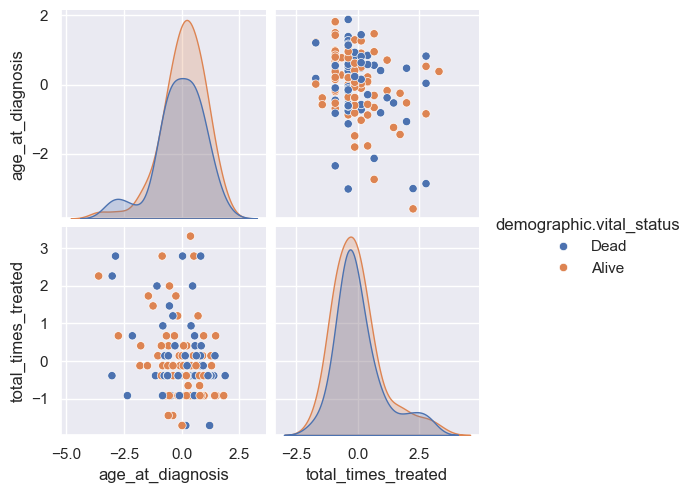

In [68]:
# scale numeric features
numeric_features = df.select_dtypes(include = "number").columns.to_list()
for f in df.columns:
    if f in numeric_features:
        reshape = df[f'{f}'].values.reshape(-1, 1)
        scaler = Scaler()
        df[f'{f}'] = scaler.fit_transform(reshape)

sns.pairplot(df[numeric_features + ['demographic.vital_status']], hue='demographic.vital_status')

In [69]:
# get categorical features
features = df.drop(['demographic.vital_status'], axis = 1)
categorical_features = features.select_dtypes(exclude = "number").columns.to_list()
print(categorical_features)

['demographic.race', 'demographic.gender', 'demographic.ethnicity', 'tissue_or_organ_of_origin', 'primary_diagnosis', 'diagnosis_is_primary_disease', 'primary_treatment', 'primary_adj_treatment', 'primary_neoadj_treatment']


In [70]:
# reducing number of categorical features, creating an "other" category for columns with smaller observations
col_names = ['primary_adj_treatment', 'tissue_or_organ_of_origin', 'primary_diagnosis', 'primary_neoadj_treatment']

# our features can be adequetly described by the 3 most common observations, except primary_adj_treatment, which should use 4
df_red = df.copy(deep=True)
# replace less common observations with "other"
for col in col_names[1:]:
    top_3_vals = df_red[col].value_counts().index[:3]
    df_red[col] = df_red[col].apply(lambda x: x if x in top_3_vals else 'Other')
top_4_vals = df_red['primary_adj_treatment'].value_counts().index[:4]
df_red['primary_adj_treatment'] = df_red['primary_adj_treatment'].apply(lambda x: x if x in top_4_vals else 'Other')

#encode categorical features 
categorical_dummies = pd.get_dummies(df_red, columns=categorical_features, drop_first = True)
encoded_df = categorical_dummies*1
encoded_df = encoded_df.drop(['demographic.vital_status'], axis = 1)
X_array = encoded_df.to_numpy()
#print(encoded_df.shape)
#print(X_array.shape)
y_array = np.array([1 if status == "Dead" else -1 for status in y])
#print(y_array.shape)

In [71]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

In [72]:
perceptron = SGDClassifier(loss='hinge', max_iter=1000, random_state=42, 
                           fit_intercept = True, alpha = .01, shuffle = False)

<h3>Model 1 with all features from the dataset</h3>

In [73]:
scores = cross_val_score(perceptron, X_array, y_array, cv=5, scoring='accuracy')
model_1_accuracy = scores.mean()
# Cross-validation results using all features
print("Cross-validation scores:", scores)
print("Mean accuracy:", model_1_accuracy)

Cross-validation scores: [0.71428571 0.78571429 0.78571429 0.67857143 0.5       ]
Mean accuracy: 0.6928571428571428


In [74]:
# fit the model and print out the weight matrix
perceptron.fit(X_array, y_array)
fin_w = np.concatenate([perceptron.intercept_, perceptron.coef_[0]])
print(fin_w) 

[ 2.31464072e-01 -7.99278988e-02  4.72411451e-04 -1.12350815e-01
  8.73839675e-02  2.49668478e-02 -6.24171196e-02 -1.27330924e+00
 -1.11102473e+00  8.98806522e-01  8.61356251e-01 -2.37185055e-01
  1.24834239e-02 -7.49005435e-02 -7.49005435e-02  2.87118750e-01
  2.49668478e-02  2.12218207e-01  1.49801087e-01  7.80919626e-17
  6.24171196e-02  1.24834239e-02]


<h3>Model 2 with 3 features chosen by coefficents from the previous model's weight matrix</h3>

In [75]:
# find the most important features by weight
abs_w = np.abs(fin_w[1:])
# sort by importance
sorted_indices = np.argsort(abs_w)[::-1]  # Sort descending by importance
# keep the top 3 features 
top_three = sorted_indices[:3]
top_features = X_array[:, top_three]
model_2_features = encoded_df.iloc[:, top_three].columns
print(model_2_features)

Index(['tissue_or_organ_of_origin_Colon, NOS',
       'tissue_or_organ_of_origin_Other',
       'tissue_or_organ_of_origin_Pancreas, NOS'],
      dtype='object')


In [76]:
# Use cross validation to determine the accuracy of the model with the new features
scores = cross_val_score(perceptron, top_features, y_array, cv=5, scoring='accuracy')
model_2_accuracy = scores.mean()
print("Cross-validation scores:", scores)
print("Mean accuracy:", model_2_accuracy)

# fit to the model and find the decision boundary
perceptron.fit(top_features, y_array)
w_final = np.concatenate([perceptron.intercept_, perceptron.coef_[0]])
print(w_final) #print final w vector

print(f"Decision Boundary: x_3 = {-(w_final[0]/w_final[3]).round(2)} + {-(w_final[1]/w_final[3]).round(2)}x_1 + {-(w_final[2]/w_final[3]).round(2)}x_2")

Cross-validation scores: [0.78571429 0.78571429 0.78571429 0.71428571 0.71428571]
Mean accuracy: 0.7571428571428572
[ 1.0000107  -2.04325    -1.98876334  0.05448667]
Decision Boundary: x_3 = -18.35 + 37.5x_1 + 36.5x_2


#### Select features using mutual information and polynomial features
Feature Selection Exploration: tests both F-score and mutual information methods for selecting key features, after generating polynomial features from numerical variables. Creates interaction 
terms and quadratic features for age and treatment count.

In [77]:
# polynomial features - numerical columns
from sklearn.preprocessing import PolynomialFeatures

numericarray = encoded_df[['age_at_diagnosis', 'total_times_treated']].values
poly = PolynomialFeatures(degree = 2, include_bias = False)
numeric_poly = poly.fit_transform(numericarray)

# add polynomial features to encoded df
poly_feature_names = ['age', 'treated', 'age^2', 'age*treated', 'treated^2']
numericpolydf = pd.DataFrame(numeric_poly, columns = ['age', 'treated', 'age^2', 'age*treated', 'treated^2'])
# drop 1st two columns because they're duplicates of the original features
numericpolydf = numericpolydf.drop(['age', 'treated'], axis=1)
encoded_df = pd.concat([encoded_df, numericpolydf], axis=1)

In [78]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# try both methods and compare
selectorf = SelectKBest(score_func=f_classif, k=10)
selectmi = SelectKBest(score_func=mutual_info_classif, k=10)

X = encoded_df
y = (y_array + 1) // 2  # Convert from [-1,1] to [0,1]

# try both selection methods
X_sel_f = selectorf.fit_transform(X, y)
X_sel_mi = selectmi.fit_transform(X, y)
# feature names both methods
selectedfeaturesf = X.columns[selectorf.get_support()].tolist()
selectedfeaturesmi = X.columns[selectmi.get_support()].tolist()

print("F-score selected features:", selectedfeaturesf)
print("Mutual info selected features:", selectedfeaturesmi)

F-score selected features: ['demographic.race_black or african american', 'demographic.race_white', 'tissue_or_organ_of_origin_Colon, NOS', 'tissue_or_organ_of_origin_Other', 'tissue_or_organ_of_origin_Pancreas, NOS', 'primary_diagnosis_Glioblastoma', 'primary_diagnosis_Malignant melanoma, NOS', 'primary_adj_treatment_Immunotherapy (Including Vaccines)', 'primary_adj_treatment_Other', 'primary_adj_treatment_Targeted Molecular Therapy']
Mutual info selected features: ['age_at_diagnosis', 'total_times_treated', 'tissue_or_organ_of_origin_Colon, NOS', 'tissue_or_organ_of_origin_Other', 'tissue_or_organ_of_origin_Pancreas, NOS', 'primary_diagnosis_Glioblastoma', 'primary_adj_treatment_Other', 'primary_adj_treatment_Radiation Therapy, NOS', 'age^2', 'treated^2']


In [79]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold

In [80]:
# trying different perceptron parameters
# for both feature sets
def evaluatemodel(X, y, alpha_value, eta0_value):
    '''
    tests how well a perceptron model performs with given settings

    Args:
    X:input features (data without the survival status)
    y: target values (survival status: 1 for dead, -1 for alive)
    alpha_value: higher = simpler model
    eta0_value: initial learning rate - how big steps to take when learning

    Returns: avg accuracy across all tests, how much the accuracy varies between tests, list of individual test scores
    
    Ex: mean_score, std_score, scores = evaluate_model(patient_data, survival_data, 0.001, 0.01)
    '''
    perceptron = SGDClassifier(loss='hinge', max_iter=2000, random_state=42, fit_intercept=True, alpha=alpha_value, shuffle=True, class_weight='balanced', learning_rate='adaptive', eta0=eta0_value)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(perceptron, X, y, cv=skf, scoring='accuracy')
    return scores.mean(), scores.std(), scores

#### Model Parameter Optimization
Performs grid search over learning rates and regularization strengths to find optimal 
hyperparameters for both feature selection approaches. Tests combinations of alpha 
(regularization) from 0.0001 to 0.01 and eta0 (initial learning rate) from 0.01 to 1.0.

In [81]:
# Try different parameters with both feature sets
alphas = [0.0001, 0.001, 0.01]
eta0s = [0.01, 0.1, 1.0]

print("\nTesting different parameters:")
print("\nWith F-score features:")
isthisbest_f = 0
bestparams_f = None
bestscores_f = None

for each in alphas:
    for eta0 in eta0s:
        mean_score, std_score, scores = evaluatemodel(X_sel_f, y_array, each, eta0)
        print(f"Alpha: {each}, eta0: {eta0}")
        print(f"Mean accuracy: {mean_score:.4f} (±{std_score:.4f})")
        print(f"Scores: {scores}\n")
        
        if mean_score > isthisbest_f:
            isthisbest_f = mean_score
            bestparams_f = (each, eta0)
            bestscores_f = scores

print("\nWith Mutual Info features:")
best_score_mi = 0
best_params_mi = None
best_scores_mi = None

for each in alphas:
    for eta0 in eta0s:
        mean_score, std_score, scores = evaluatemodel(X_sel_mi, y_array, each, eta0)
        print("alpha: " + str(each) + ", eta0: " + str(eta0))
        print("mean accuracy: " + str(round(mean_score, 4)) + " (±" + str(round(std_score, 4)) + ")")
        print("scores: " + str(scores) + "\n")
        
        if mean_score > best_score_mi:
            best_score_mi = mean_score
            best_params_mi = (each, eta0)
            best_scores_mi = scores


Testing different parameters:

With F-score features:
Alpha: 0.0001, eta0: 0.01
Mean accuracy: 0.7571 (±0.0763)
Scores: [0.82142857 0.64285714 0.75       0.85714286 0.71428571]

Alpha: 0.0001, eta0: 0.1
Mean accuracy: 0.7429 (±0.0614)
Scores: [0.82142857 0.64285714 0.75       0.78571429 0.71428571]

Alpha: 0.0001, eta0: 1.0
Mean accuracy: 0.7429 (±0.0614)
Scores: [0.82142857 0.64285714 0.75       0.78571429 0.71428571]

Alpha: 0.001, eta0: 0.01
Mean accuracy: 0.7571 (±0.0763)
Scores: [0.82142857 0.64285714 0.75       0.85714286 0.71428571]

Alpha: 0.001, eta0: 0.1
Mean accuracy: 0.7429 (±0.0614)
Scores: [0.82142857 0.64285714 0.75       0.78571429 0.71428571]

Alpha: 0.001, eta0: 1.0
Mean accuracy: 0.7429 (±0.0614)
Scores: [0.82142857 0.64285714 0.75       0.78571429 0.71428571]

Alpha: 0.01, eta0: 0.01
Mean accuracy: 0.7571 (±0.0763)
Scores: [0.82142857 0.64285714 0.75       0.85714286 0.71428571]

Alpha: 0.01, eta0: 0.1
Mean accuracy: 0.7500 (±0.0678)
Scores: [0.82142857 0.64285714 

In [82]:
# Print best results
print("\nbest results:")
print("F-score method - Best accuracy: " + str(round(isthisbest_f, 4)))
print("best parameters: alpha=" + str(bestparams_f[0]) + ", eta0=" + str(bestparams_f[1]))
print("scores: " + str(bestscores_f))

print("\nmutual info method - best accuracy: " + str(round(best_score_mi, 4)))
print("best parameters: alpha=" + str(best_params_mi[0]) + ", eta0=" + str(best_params_mi[1]))
print("scores: " + str(best_scores_mi))


best results:
F-score method - Best accuracy: 0.7571
best parameters: alpha=0.0001, eta0=0.01
scores: [0.82142857 0.64285714 0.75       0.85714286 0.71428571]

mutual info method - best accuracy: 0.7357
best parameters: alpha=0.0001, eta0=0.01
scores: [0.82142857 0.64285714 0.71428571 0.78571429 0.71428571]


Both feature selection methods achieved comparable accuracy (~75-76%), with F-score 
slightly outperforming mutual information. F-score performed best with lower 
α=0.0001 and η=0.01, while mutual info needed stronger regularization, α=0.01, and higher η=0.1. Cross-validation scores show consistent performance, and accuracy ranges from 64-86%.

### Visualizing linear perceptron models performance -- comparison 
We created a bar chart to compare the accuracy scores of the linear perceptron models tested with different combinations of the alpha and eta0 hyperparameters. The x-axis is the specific alpha & eta0 values, the y-axis is the corresponding accuracy scores. 

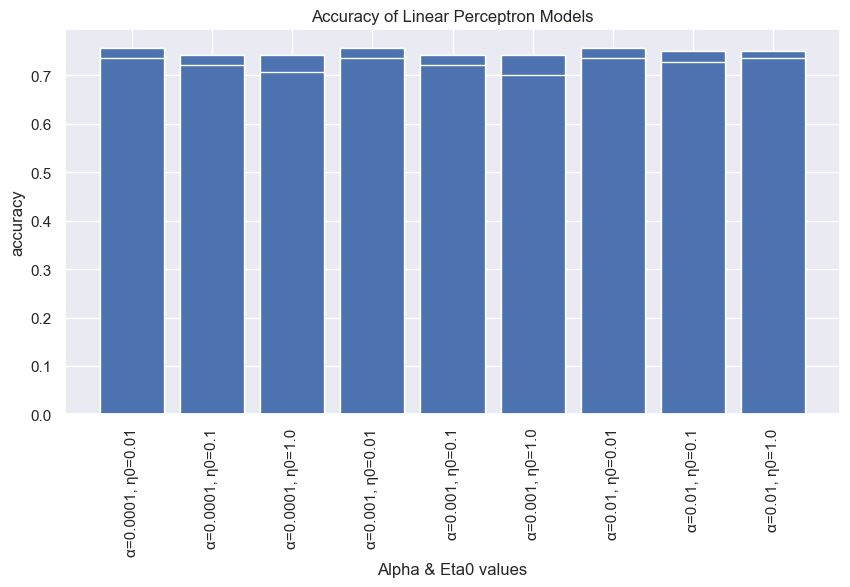

In [83]:
alpha_eta0_together = []
for alpha in [0.0001, 0.001, 0.01]:
   for eta0 in [0.01, 0.1, 1.0]:
       mean_score, _, _ = evaluatemodel(X_sel_f, y_array, alpha, eta0)
       alpha_eta0_together.append((alpha, eta0, mean_score))
for alpha in [0.0001, 0.001, 0.01]:
   for eta0 in [0.01, 0.1, 1.0]:
       mean_score, _, _ = evaluatemodel(X_sel_mi, y_array, alpha, eta0)
       alpha_eta0_together.append((alpha, eta0, mean_score))

# bar chart
plt.figure(figsize=(10, 5))
x = [f"α={a}, η0={e}" for a, e, _ in alpha_eta0_together]
y = [m for _, _, m in alpha_eta0_together]
colors = ['pink', 'lightskyblue', 'lightgreen', 'lightsalmon', 'plum', 'lightcyan']
plt.bar(x, y, color=colors)
plt.bar(x, y)
plt.xticks(rotation=90)
plt.xlabel('Alpha & Eta0 values')
plt.ylabel('accuracy')
plt.title('Accuracy of Linear Perceptron Models')
plt.show()

In [84]:
# implementing final model w best parameters from F-score method
# using the best alpha and eta0 we found:
# alpha=bestparams_f[0], eta0=bestparams_f[1]
# then using F-score selected features for chosen model
chosenperceptron = SGDClassifier(loss='hinge', max_iter=2000, random_state=42, fit_intercept=True, alpha=bestparams_f[0], eta0=bestparams_f[1], shuffle=True, class_weight='balanced', learning_rate='adaptive')
X_final = X_sel_f
y_final = y_array

# fiting the model & feature importance
chosenperceptron.fit(X_final, y_final)
fe_importance = np.abs(chosenperceptron.coef_[0])
fe_importance_dict = dict(zip(selectedfeaturesf, fe_importance))
print("\nchosen model feature importance scores:")
print("\n")
for feature, importance in sorted(fe_importance_dict.items(), key=lambda x: abs(x[1]), reverse=True):
    print(feature + ": " + str(round(importance, 4)))


chosen model feature importance scores:


tissue_or_organ_of_origin_Colon, NOS: 1.1995
tissue_or_organ_of_origin_Other: 1.0071
primary_diagnosis_Glioblastoma: 0.9732
tissue_or_organ_of_origin_Pancreas, NOS: 0.972
primary_adj_treatment_Immunotherapy (Including Vaccines): 0.2472
primary_diagnosis_Malignant melanoma, NOS: 0.0855
demographic.race_white: 0.0361
primary_adj_treatment_Targeted Molecular Therapy: 0.013
primary_adj_treatment_Other: 0.0053
demographic.race_black or african american: 0.0026


The horizontal bar chart ranks each feature's predictive power for patient survival. Location of cancer is the strongest predictor, with colon cancer showing the highest importance score (1.2), followed by other organ types and glioblastoma. Treatment methods like immunotherapy show moderate importance (0.4), while demographic factors like race have minimal impact (< 0.1). We've simplified the feature names by removing database prefixes and standardizing formatting for clearer interpretation.

### Linear Perceptron Results Summary:
- Narrowing down features did  improve the model, with Model 1 having an accuracy score of 0.69 and Models 2 & 3 having an accuracy score of 0.75
- Between Models 2 & 3, accuracy did not improve, as the other features that were in Model 3 but not in Model 2 did not hold much importance to the classification
- Most important features was cancer organ location
- Arranged by decreasing importance: type of cancer, treatment type, and demographic factors all have relatively minor impacts compared to location

In [85]:
model = ["All features", "Top 3 features", "F-score selected Features"]
score = [model_1_accuracy, model_2_accuracy, isthisbest_f]

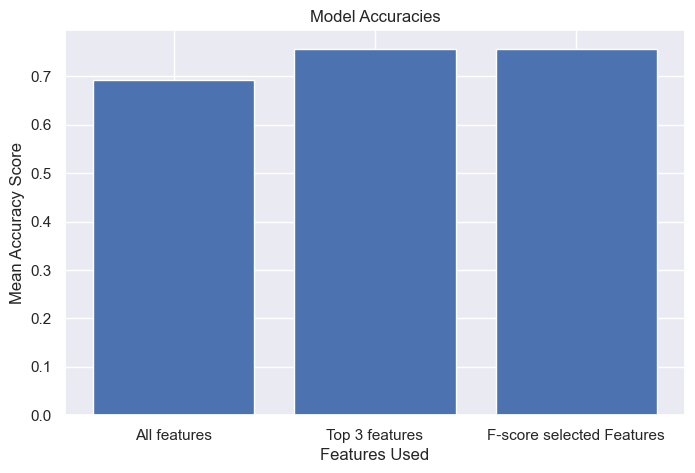

In [86]:
plt.figure(figsize=(8, 5))
plt.bar(model, score)
plt.title("Model Accuracies")
plt.ylabel("Mean Accuracy Score")
plt.xlabel("Features Used")
plt.show()

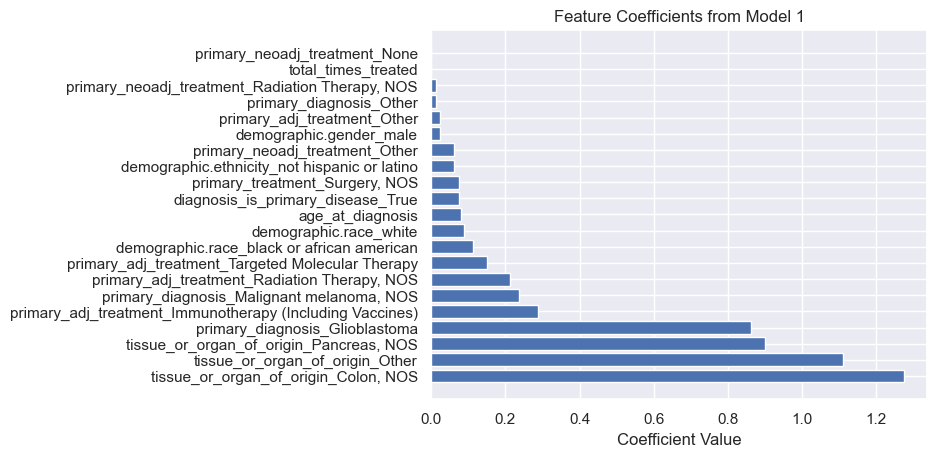

In [93]:
all_feats = list(encoded_df)
weights = list(np.abs(fin_w[1:]))
sorted_indices = np.argsort(weights)[::-1]  # Indices of sorted weights
sorted_weights = [weights[i] for i in sorted_indices]
sorted_feats = [all_feats[i] for i in sorted_indices]
plt.title("Feature Coefficients from Model 1")
plt.xlabel("Coefficient Value")
plt.barh(sorted_feats, sorted_weights)
plt.show()

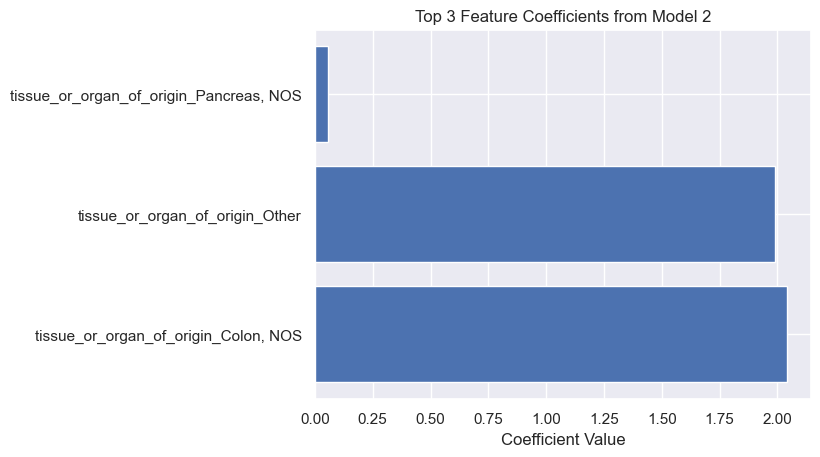

In [88]:
features = list(model_2_features)
weights = list(np.abs(w_final[1:]))
plt.title("Top 3 Feature Coefficients from Model 2")
plt.xlabel("Coefficient Value")
plt.barh(features, weights)
plt.show()

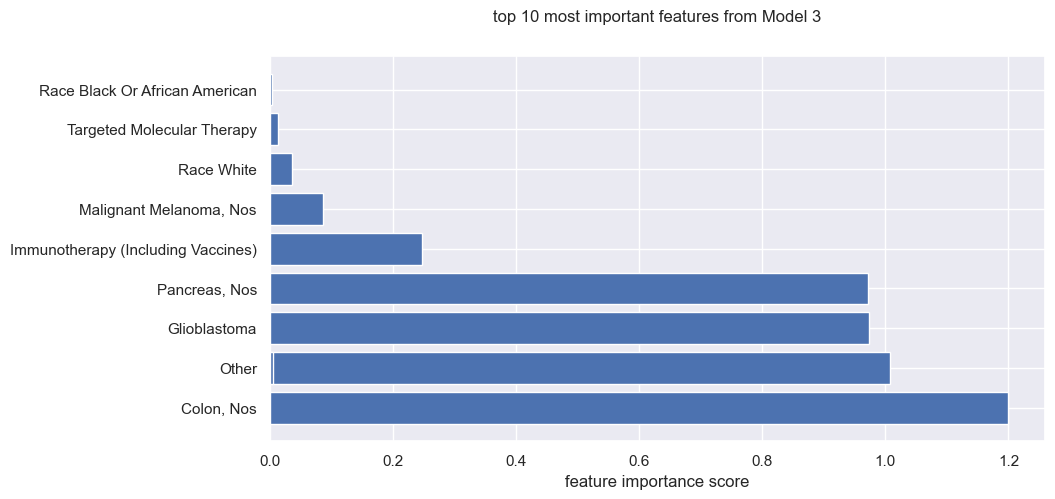

In [94]:
# feature importance bar plot
fe_importance_dict = dict(zip(selectedfeaturesf, fe_importance))
sorted_features = sorted(fe_importance_dict.items(), key=lambda x: x[1], reverse=True)
features, importance = zip(*sorted_features)

# removing stuff to make more readable
removingstuff = [f.replace('tissue_or_organ_of_origin_', '')
                     .replace('primary_diagnosis_', '')
                     .replace('primary_adj_treatment_', '')
                     .replace('demographic.', '')
                     .replace('_', ' ')
                     .title() for f in features]

# bar plot 
plt.figure(figsize=(10, 5))
plt.barh(removingstuff, importance)
plt.title('top 10 most important features from Model 3', pad=25)
plt.xlabel('feature importance score')
plt.show()